In [157]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **PROBLEM STATEMENT**

**DOMAIN**: Industrial safety. NLP based Chatbot.

**CONTEXT:**
The  database  comes  from one  of  the  biggest  industry  in  Brazil  and  in  the  world.  It  is  an  urgent  need  for  industries/companies  around  the globe to understand why employees still suffer some injuries/accidents in plants. Sometimes they also die in such environment.

**DATA DESCRIPTION:**
This  The  database  is  basically  records  of  accidents  from12  different  plants  in  03  different  countrieswhich  every  line  in  the  data  is  an occurrence of an accident.

**Columns description:**
- `Data`: timestamp or time/date information
- `Countries`: which country the accident occurred (anonymised)
- `Local`: the city where the manufacturing plant is located (anonymised)
- `Industry sector`: which sector the plant belongs to
- `Accident level`: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)
- `Potential Accident Level`: Depending on the Accident Level, the database also registers how severe the accident could have been (due to other factors involved in the accident)
- `Genre`: if the person is male of female
- `Employee or Third Party`: if the injured person is an employee or a third party
- `Critical Risk`: some description of the risk involved in the accident
- `Description`: Detailed description of how the accident happened.

**PROJECT OBJECTIVE:**
Design  a  ML/DL  based  chatbot  utility  which  can  help  the  professionals  to  highlight  the  safety  risk  as  per  the  incident description.

In [158]:
pip install  pyspellchecker

In [159]:
import pandas as pd
pd.set_option('max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
# Deep Learning library
import torch
nltk.download('stopwords')    # loading the stopwords
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
# to remove common stop words
from nltk.corpus import stopwords
from spellchecker import SpellChecker
# to visualize text data using wordcloud
# from wordcloud import STOPWORDS

# to perform stemming
from nltk.stem.porter import PorterStemmer
#to perform lemmentization
from nltk.stem import WordNetLemmatizer

# to perform tokenization
from nltk.tokenize import word_tokenize, sent_tokenize

# Importing the SpaCy library
# To create Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

# To create TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# To import Word2Vec
from gensim.models import Word2Vec

# To split data into train and test sets
from sklearn.model_selection import train_test_split

# To build a Random Forest model
from sklearn.ensemble import RandomForestClassifier

# To compute metrics to evaluate the model
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

sns.set_style("whitegrid")

from nltk.corpus import wordnet

import random

# to ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [160]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### **Import the dataset and overview**

In [161]:
# Read the xlsx dataset and create a copy of it
#dataset = pd.read_excel('DataSet_industrial_safety_and_health_database_with_accidents_description.xlsx')
dataset = pd.read_excel('/content/drive/MyDrive/Data/DataSet_industrial_safety_and_health_database_with_accidents_description.xlsx')
#dataset = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Capstone/NLPChatbot/DataSet_industrial_safety_and_health_database_with_accidents_description.xlsx')
df = dataset.copy()

FileNotFoundError: [Errno 2] No such file or directory: 'DataSet_industrial_safety_and_health_database_with_accidents_description.xlsx'

In [ ]:
# Display the first 3 rows of the dataset
df.head(3)

In [ ]:
# Display the last 3 rows of the dataset
df.tail(3)

In [ ]:
# Print the shape of the dataset
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns')

### **Data cleaning and analysis**

**Observations from visual analysis of the excel dataset:**
- Column `Unnamed: 0` looks like the row index, and seem to serve no purpose. We shall drop this column.
- Column `Data` is actually the `Date` column and should be renamed so.
- Column `Genre` should be renamed as `Gender` for better understanding. It only has values - `Male` and `Female`.
- Column `Employee or Third Party` can be renamed as `Employee_Type` for better understanding.
- Column `Countries` represent a single country, and should be renamed as `Country` for better representation.
- Column `Local` represents the location, and should be renamed same for better representation.
- We also replace spaces from the column names with `_` for simplicity in programming.

In [ ]:
# Drop the 'Unnamed: 0' column
df.drop('Unnamed: 0', axis=1, inplace=True)

# Rename the columns
df.rename(columns={
    'Data':'Date',
    'Countries':'Country',
    'Local':'Location',
    'Industry Sector':'Industry_Sector',
    'Accident Level':'Accident_Level',
    'Potential Accident Level':'Potential_Accident_Level',
    'Genre':'Gender',
    'Employee or Third Party':'Employee_Type',
    'Critical Risk':'Critical_Risk'
}, inplace=True)

In [ ]:
# Observe couple of rows to see the changes
df.head(2)

#### Check for missing or null values or duplicate records

In [ ]:
# Check information about the dataset
df.info()

In [ ]:
# Check for missing values
df.isnull().sum()

**Observation:** None of the columns have null values.

In [ ]:
# Check for duplicate values
df.duplicated().sum()

**Observation:** There are 7 duplicate records.

In [ ]:
# Drop the duplicate values
df.drop_duplicates(inplace=True)
df=df.reset_index(drop=True)
df.shape

In [ ]:
# Check for duplicate values
df.duplicated().sum()

In [ ]:
#checking to see  if there are repeated description in our data

df['Description'].duplicated().sum()

**Observations** : There are 7 rows that have duplicate descriptions

In [ ]:
df[df['Description'].duplicated(keep=False)]

* 7 accident descriptions are repeated in the data.
* These are accidents which happened at the same time where a group was invovled and there are different records for each person.  
* As this corresponds to different records, we will not remove the repeated descriptions and keep them as it is.

**We now have 418 records after 7 duplicate rows have been removed**

#### Date processing
Let us break the Date in Year, Month and Day which would help in further processing.

In [ ]:
df_proc_1 = df.copy()

df_proc_1['Date'] = pd.to_datetime(df_proc_1['Date'])
df_proc_1['Year'] = df_proc_1['Date'].dt.year
df_proc_1['Month'] = df_proc_1['Date'].dt.month_name()
df_proc_1['Day'] = df_proc_1['Date'].dt.day
df_proc_1['Weekday'] = df_proc_1['Date'].dt.day_name()
df_proc_1.drop(columns=['Date'], inplace=True)

df_proc_1.head(3)

In [ ]:
# Select all columns except 'Description'
df_temp = df_proc_1.loc[:, df_proc_1.columns != 'Description']

# Function to display unique values in each column except 'Date' and 'Description'
def unique_values(df_temp):
    for column in df_temp.columns:
        print(f'{column}: {df_temp[column].unique()}')
        print('-----------------------------------')

unique_values(df_temp)

Looking at the above output, we may drop the Year and Day columns as they seem irrelevant for the analysis.

In [ ]:
# Drop the Day and Year columns
df_proc_1.drop(columns=['Year', 'Day'], inplace=True)
df_proc_1.head(3)

## **Exploratory Data Analysis**

### **Univariate analysis**

#### **Distribution of individual columns**

In [ ]:
df_proc_1.columns

In [ ]:
# Function to plot distribution of each column
def plot_countplot(df_temp, column):
    plt.figure(figsize=(20, 6))
    sns.countplot(data=df_temp, x=column, order=df_temp[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.ylabel('Frequency')

    # Annotate the frequency percentage of each label
    total = len(df_temp[column])
    for p in plt.gca().patches:
        height = p.get_height()
        percentage = f'{height / total:.2%}'
        plt.gca().annotate(f'{percentage}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    plt.show()

##### Country

In [ ]:
plot_countplot(df_proc_1, 'Country')

We have data for 3 countries, 60% of the data is for Country_01, 31% for countrty_02 and only 10% for country_03. It is possible country_01 is more prone to accidents, or there is data imbalace. Need to check if there is some relationships between country and accidents

##### Location

In [ ]:
plot_countplot(df_proc_1, 'Location')

##### Industry Sector

In [ ]:
plot_countplot(df_proc_1, 'Industry_Sector')

##### Accident Level

Because of the nature of work Mining sector is more prone to accidents then Metals and others which is also being reflected in the data.

In [ ]:
plot_countplot(df_proc_1, 'Accident_Level')

there are around 2% of accidents in severe category 5. Though there is no data for accidents in level 6 which is the highest category.

##### Potential Accident Level

In [ ]:
plot_countplot(df_proc_1, 'Potential_Accident_Level')

There are 34% scenarios where the accidents could be as severe as range 4, followed by 25.3% of level 3. Also 0.24% chances of the most severe level 6.

##### Gender

In [ ]:
plot_countplot(df_proc_1, 'Gender')

##### Employee Type

In [ ]:
plot_countplot(df_proc_1, 'Employee_Type')

##### Critical Risk

In [ ]:
plot_countplot(df_proc_1, 'Critical_Risk')

##### Month

In [ ]:
plot_countplot(df_proc_1, 'Month')

##### Weekday

In [ ]:
plot_countplot(df_proc_1, 'Weekday')

### Observations from the above univariate vizualization are:

**Country**
- Data is available for only 3 countries. Country_01 is most pront to accidents followed by country 2

**Industry Sector**
- Mining sector has the most accident cases than any other sector. Thus, we can say that jobs in the mining industry sector are more risky than metal or any other sector.

**Gender**
- Dataset is more biased towards male employees, this is possible because Mining and Metal industries are more male dominant.  

**Employee type**
- Total number of internal employees and Third Party employees is more or less the same. But, we can also see that Third party remote employees are comparatively less in number.

**Local**
- There is data for 12 locations across 3 countries. Local_03 has seen the maximum number of accidents, which is around 20% of all the accident cases recorded.

**Critical Risk**
- Most of the Critical Risks are classified as 'Others'. It holds around 55% of the total Critical Risks. It is followed by Pressed, Manual tools, Chemical substances, etc.

**Accident Level**
- Accident levels are mostly of Level 1 with 74% of the data, followed by 9/.5% of level 2 and ~7% for levels 3 and 4 and ~2% for level 5. There have been no accidents of level 6 which is the highest level.

**Potential Accident Level**
- Potential accident level indicates how severe the accident would have been due to other factors involved in the accidents. As per the graph, level IV has the highest count, which corresponds to moderate severity of accidents.


### **Bivariate Analysis**

In [151]:
# Function to plot the distribution of accident levels by input column
def plot_accident_levels(df_temp, column,targetColumn,targetColumnName, figsize=(20, 6), title_fontsize=10, label_fontsize=10, ticks_fontsize=10):
    plt.figure(figsize=figsize)
    # Specify the desired order for the legend
    hue_order = ['I', 'II','III','IV','V','VI']
    sns.countplot(data=df_temp, x=column, hue=targetColumn,hue_order=hue_order,order=df_temp[column].value_counts().index, palette='Set2', dodge=True)
    #sns.countplot(data=df_temp, x=column, hue=targetColumn, dodge=False)
    plt.title(f'Distribution of {targetColumnName} Levels by {column}', fontsize=title_fontsize)
    plt.xlabel(column, fontsize=label_fontsize)
    plt.xticks(rotation=90, fontsize=ticks_fontsize)
    plt.ylabel('Frequency', fontsize=label_fontsize)
    plt.legend(title=targetColumnName, fontsize=ticks_fontsize, title_fontsize=label_fontsize
               ,handlelength=3,      # Length of legend handles
              handleheight=2,      # Height of legend handles
              labelspacing=1.5,    # Space between legend labels
                borderpad=  2          # Padding inside the legend box
               )
    plt.show()

In [ ]:
# Defining a function to further create Pie Charts

def plot_each_pieChart(df_temp,columnName,columnValue,targetColumn ,targetColumnName):
  # Get colors from a Seaborn palette
  colors = sns.color_palette('deep',df_temp[targetColumn].nunique())

  plt.pie(df_temp[df_temp[columnName]==columnValue][targetColumn].value_counts()
          ,labels=df_temp[df_temp[columnName]==columnValue][targetColumn].value_counts().index
          , colors=colors
          ,autopct='%1.1f%%');

def plot_pieChartshowAllPiesForColumn(df_temp, columnName,targetColumn,targetColumnName, columnsPerRow):
  noOfUniques=len(df_temp[columnName].unique())
  noOfColumns=columnsPerRow
  noOfRows=int(np.ceil(noOfUniques/noOfColumns))
  #fig, axes = plt.subplots(noOfRows,noOfColumns, figsize=(noOfColumns*5,noOfRows*5))
  #fig.tight_layout()
  plt.figure(figsize=(noOfColumns*4,noOfRows*4));
  for i, column in enumerate(df_temp[columnName].unique()):
    plt.subplot(noOfRows,noOfColumns,i+1)
    plot_each_pieChart(df_temp,columnName,column,targetColumn,targetColumnName)
    plt.title(f'{targetColumnName} vs '+column, fontsize=10)
  plt.show()

In [ ]:
# Defining a function to further create Pie Charts

def plot_each_pieChart(df_temp,columnName,columnValue,targetColumn ):
  plt.pie(df_temp[df_temp[columnName]==columnValue][targetColumn].value_counts(),labels=df_temp[df_temp[columnName]==columnValue][targetColumn].value_counts().index,autopct='%1.1f%%');

def plot_pieChartshowAllPiesForColumn(df_temp, columnName,targetColumn,columnsPerRow):
  noOfUniques=len(df_temp[columnName].unique())
  noOfColumns=columnsPerRow
  noOfRows=int(np.ceil(noOfUniques/noOfColumns))
  #fig, axes = plt.subplots(noOfRows,noOfColumns, figsize=(noOfColumns*5,noOfRows*5))
  #fig.tight_layout()
  plt.figure(figsize=(noOfColumns*4,noOfRows*4));
  for i, column in enumerate(df_temp[columnName].unique()):
    plt.subplot(noOfRows,noOfColumns,i+1)
    plot_each_pieChart(df_temp,columnName,column,targetColumn)
    plt.title('Accident Level vs '+column)
  plt.show()

#### **Distribution of features by Accident Level**

##### Accidents by Country

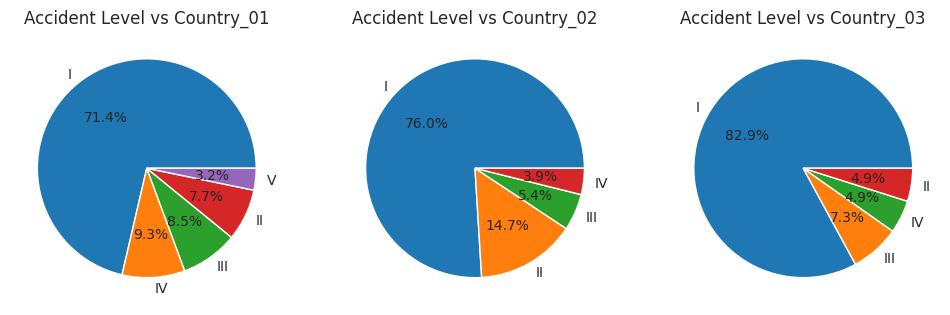

In [ ]:
plot_pieChartshowAllPiesForColumn(df_proc_1, 'Country','Accident_Level', 3)

* More than 70% accidents in all three countries are Level 1 accidents.
* Severity of accidents are highest in count_01. All the Level 5 accidents occured only in country_01. It would be interesting to investigate further to know the reason for this. Why the most severe accidents are specific to country_01?

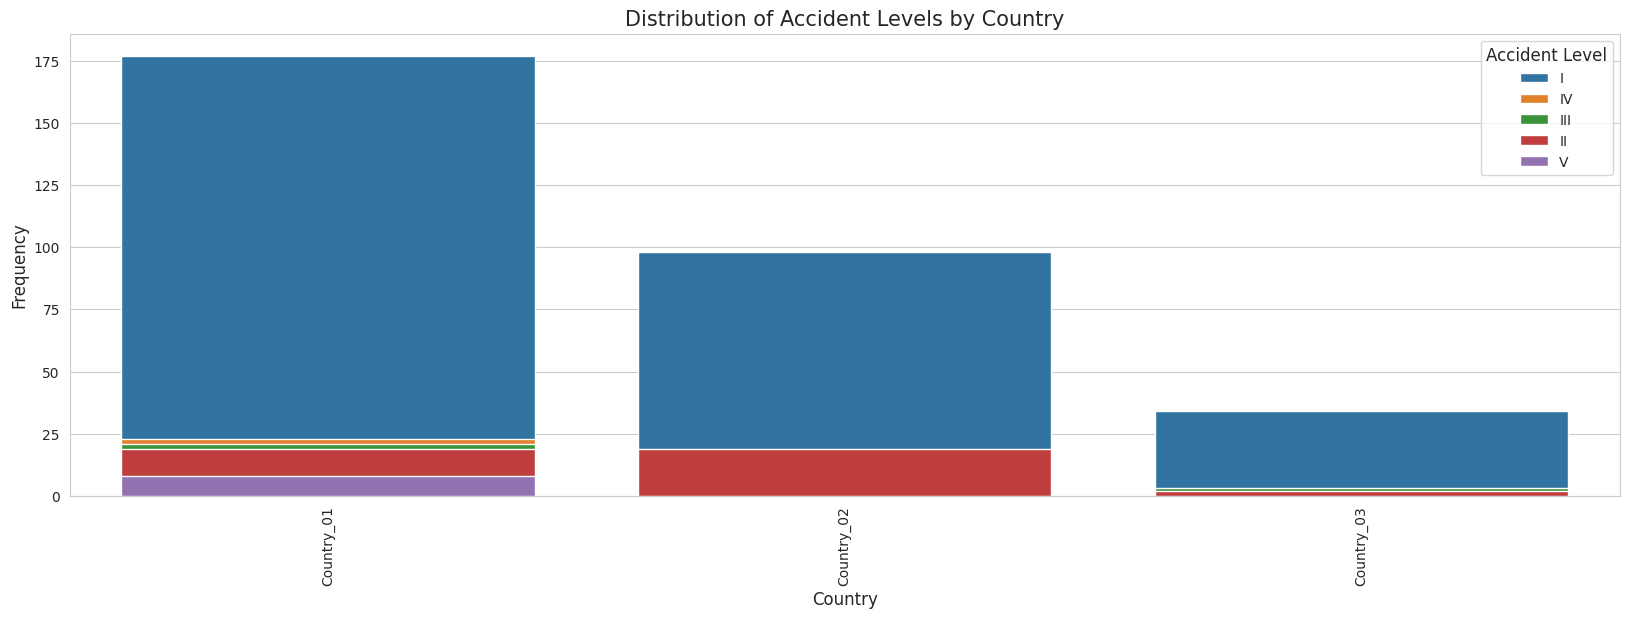

In [ ]:
plot_accident_levels(df_proc_1, 'Country')

##### Accidents by Location

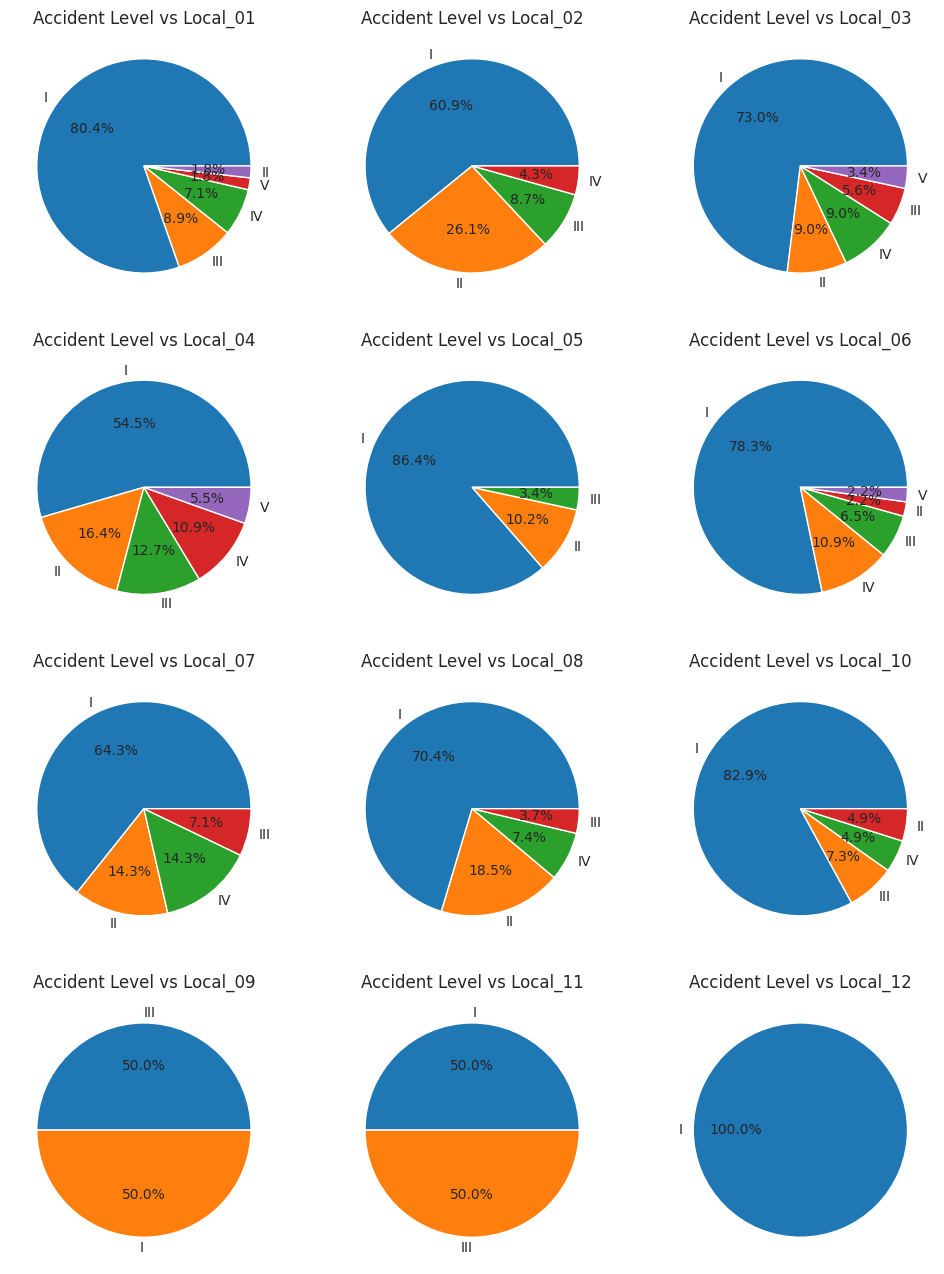

In [ ]:
plot_pieChartshowAllPiesForColumn(df_proc_1, 'Location','Accident_Level', 3)

1.   Majority of accidents in all localities are level 1 accidents. (In fact,   local_12 observed only level 1 accidents.)

2. Local_09 and local_11 observed only level 1 and 3 accidents, that too in equal proportion.

3. We can observe that the proportion of Level 4 and level 5 accidents is the highest in local_04.

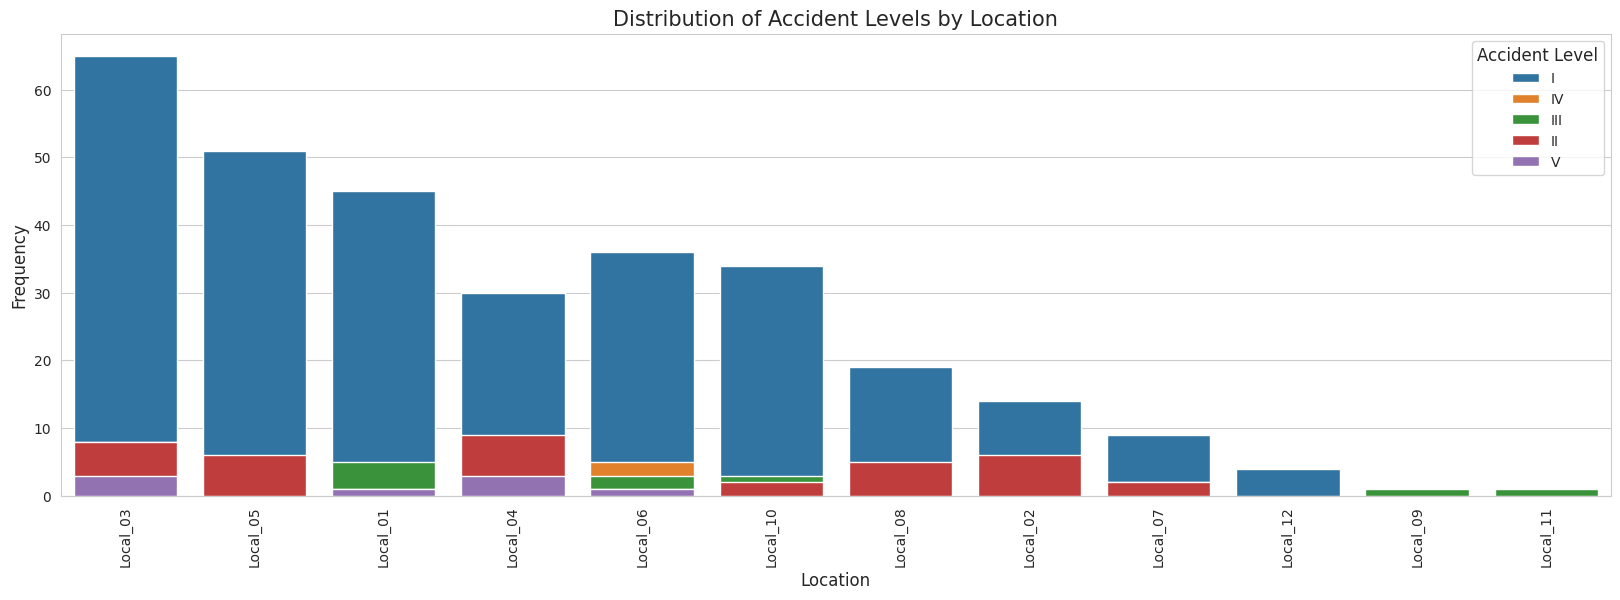

In [ ]:
plot_accident_levels(df_proc_1, 'Location')

##### Accidents by Industry Sector

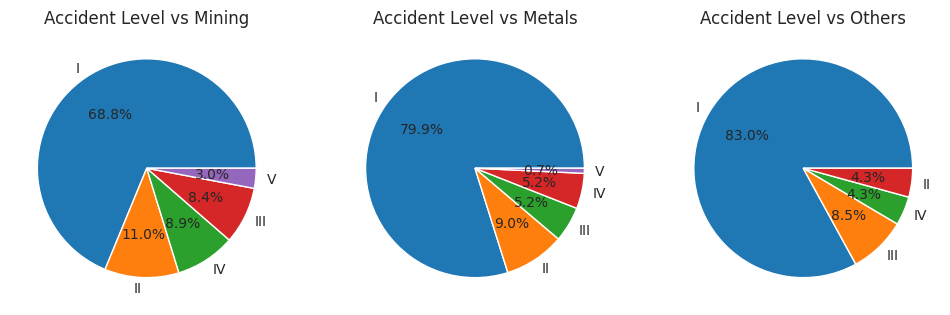

In [ ]:
plot_pieChartshowAllPiesForColumn(df_proc_1, 'Industry_Sector','Accident_Level', 3)

1. Mining sector has highest proportion of level 4 and level 5 accidents among all the sectors.
2. Proportion of level 1 accidents is highest in Others Sector.

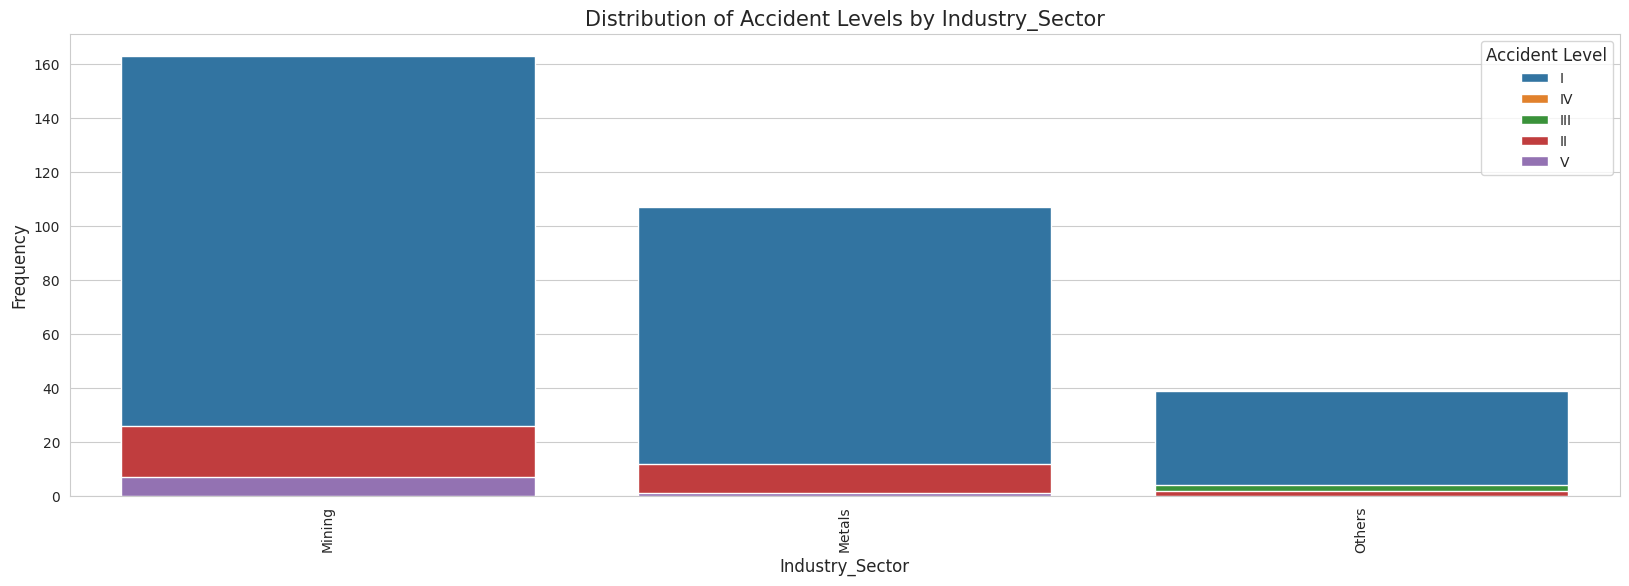

In [ ]:
plot_accident_levels(df_proc_1, 'Industry_Sector')

##### Accidents by Gender

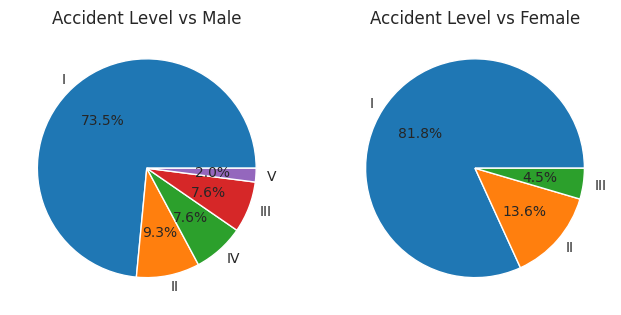

In [ ]:
plot_pieChartshowAllPiesForColumn(df_proc_1, 'Gender','Accident_Level', 3)

1. Men have faced more severe accidents than women.
2. Around 10% of overall accidents faced by men are level 4 and level 5 accidents, whereas women did not face any level 4 or 5 accident.
3. More than 80% of accidents faced by women are level 1 accidents.

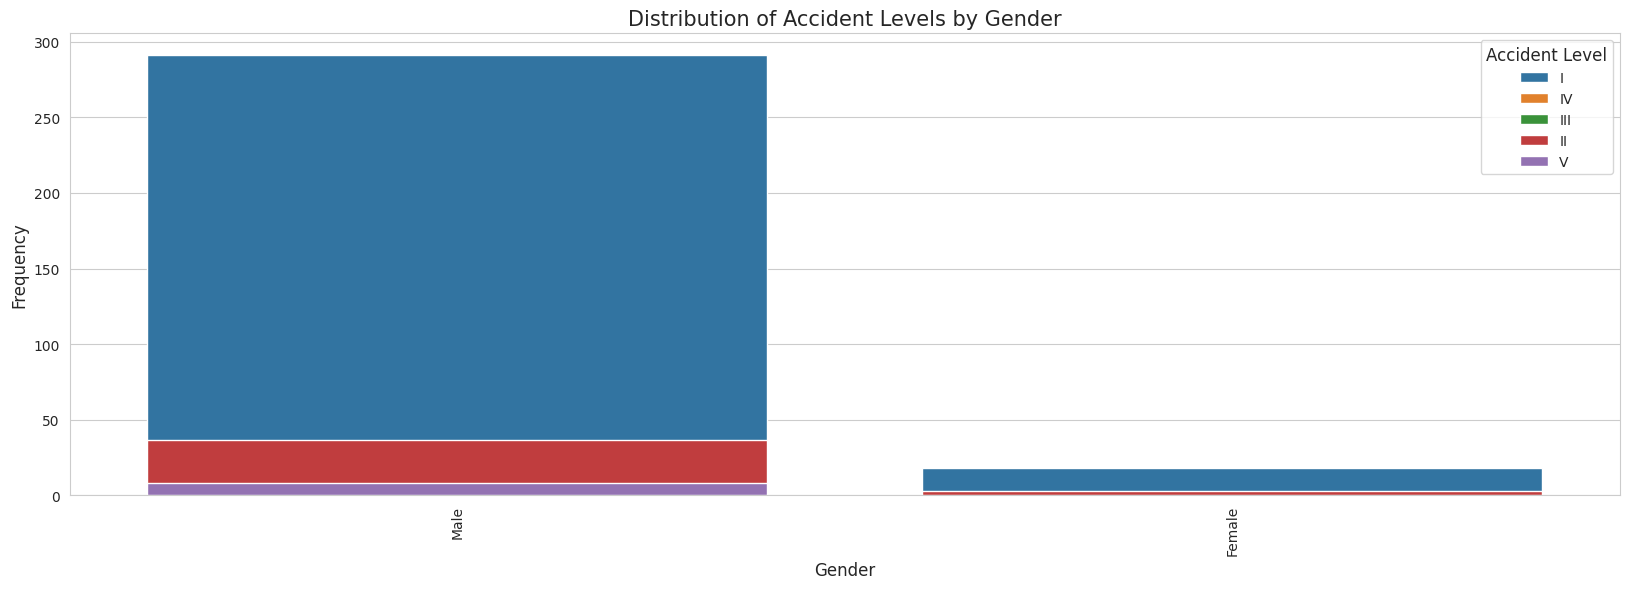

In [ ]:
plot_accident_levels(df_proc_1, 'Gender')

##### Accidents by Employee Type

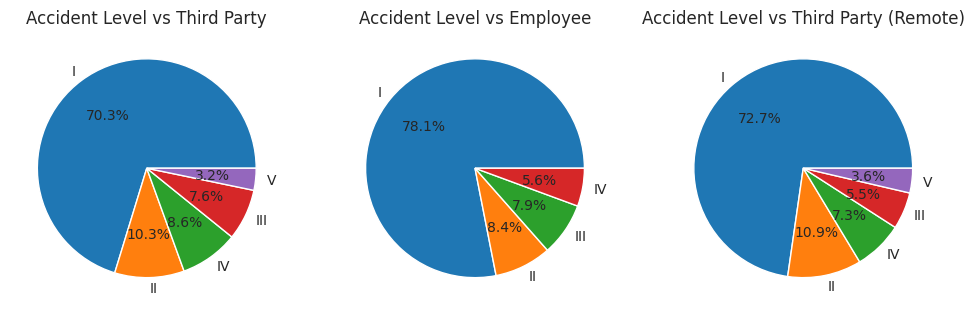

In [ ]:
plot_pieChartshowAllPiesForColumn(df_proc_1, 'Employee_Type','Accident_Level', 3)

1. Level 1 accidents for all employee types is over 70%.
2. Internal employees did not face any level 5 accident, whereas proportion of level 5 accidents for both Third Party and Third Party remote is roughly the same.
3. This tells us that it is slightly more risky to be a Third party or remote employee than to be an internal employee.

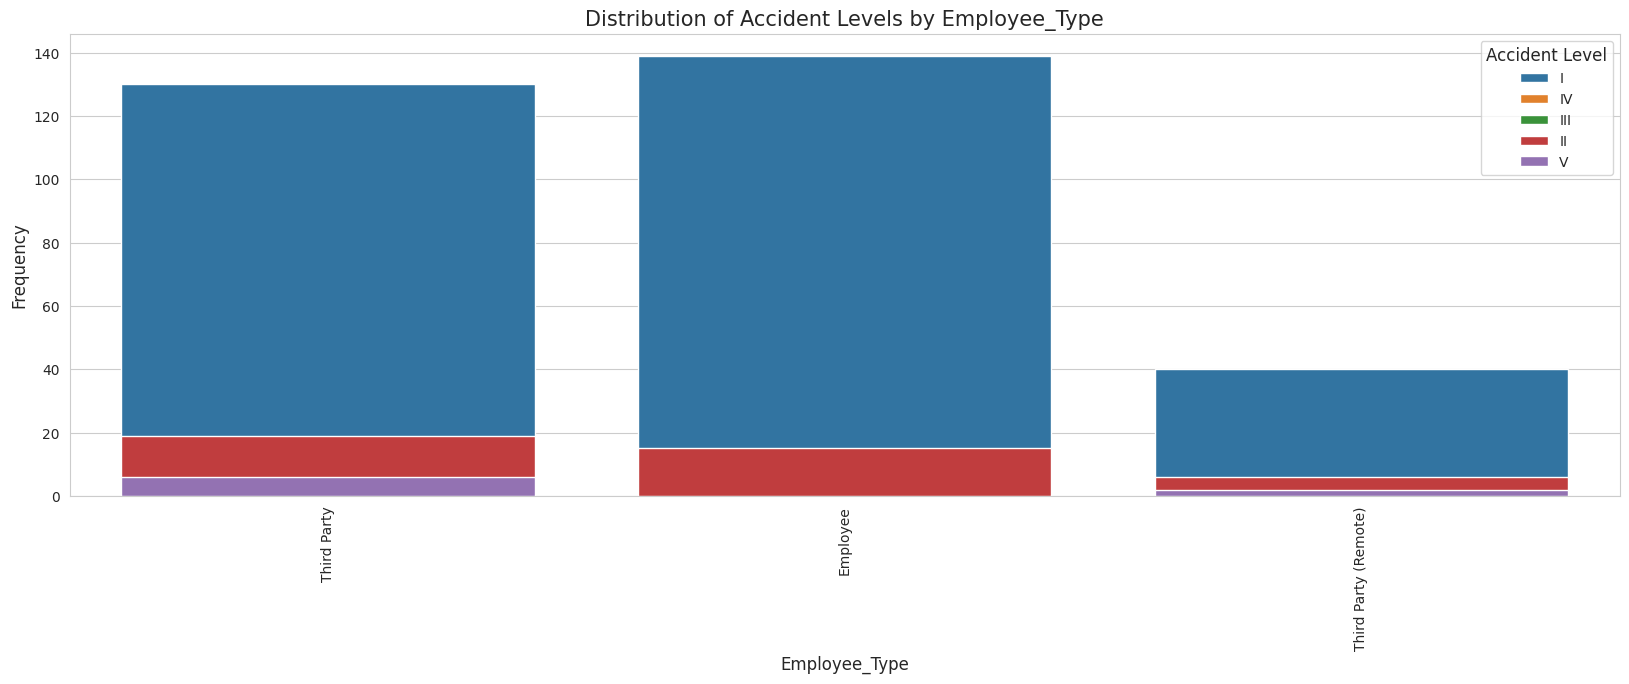

In [ ]:
plot_accident_levels(df_proc_1, 'Employee_Type')

##### Accidents by Critical Risk

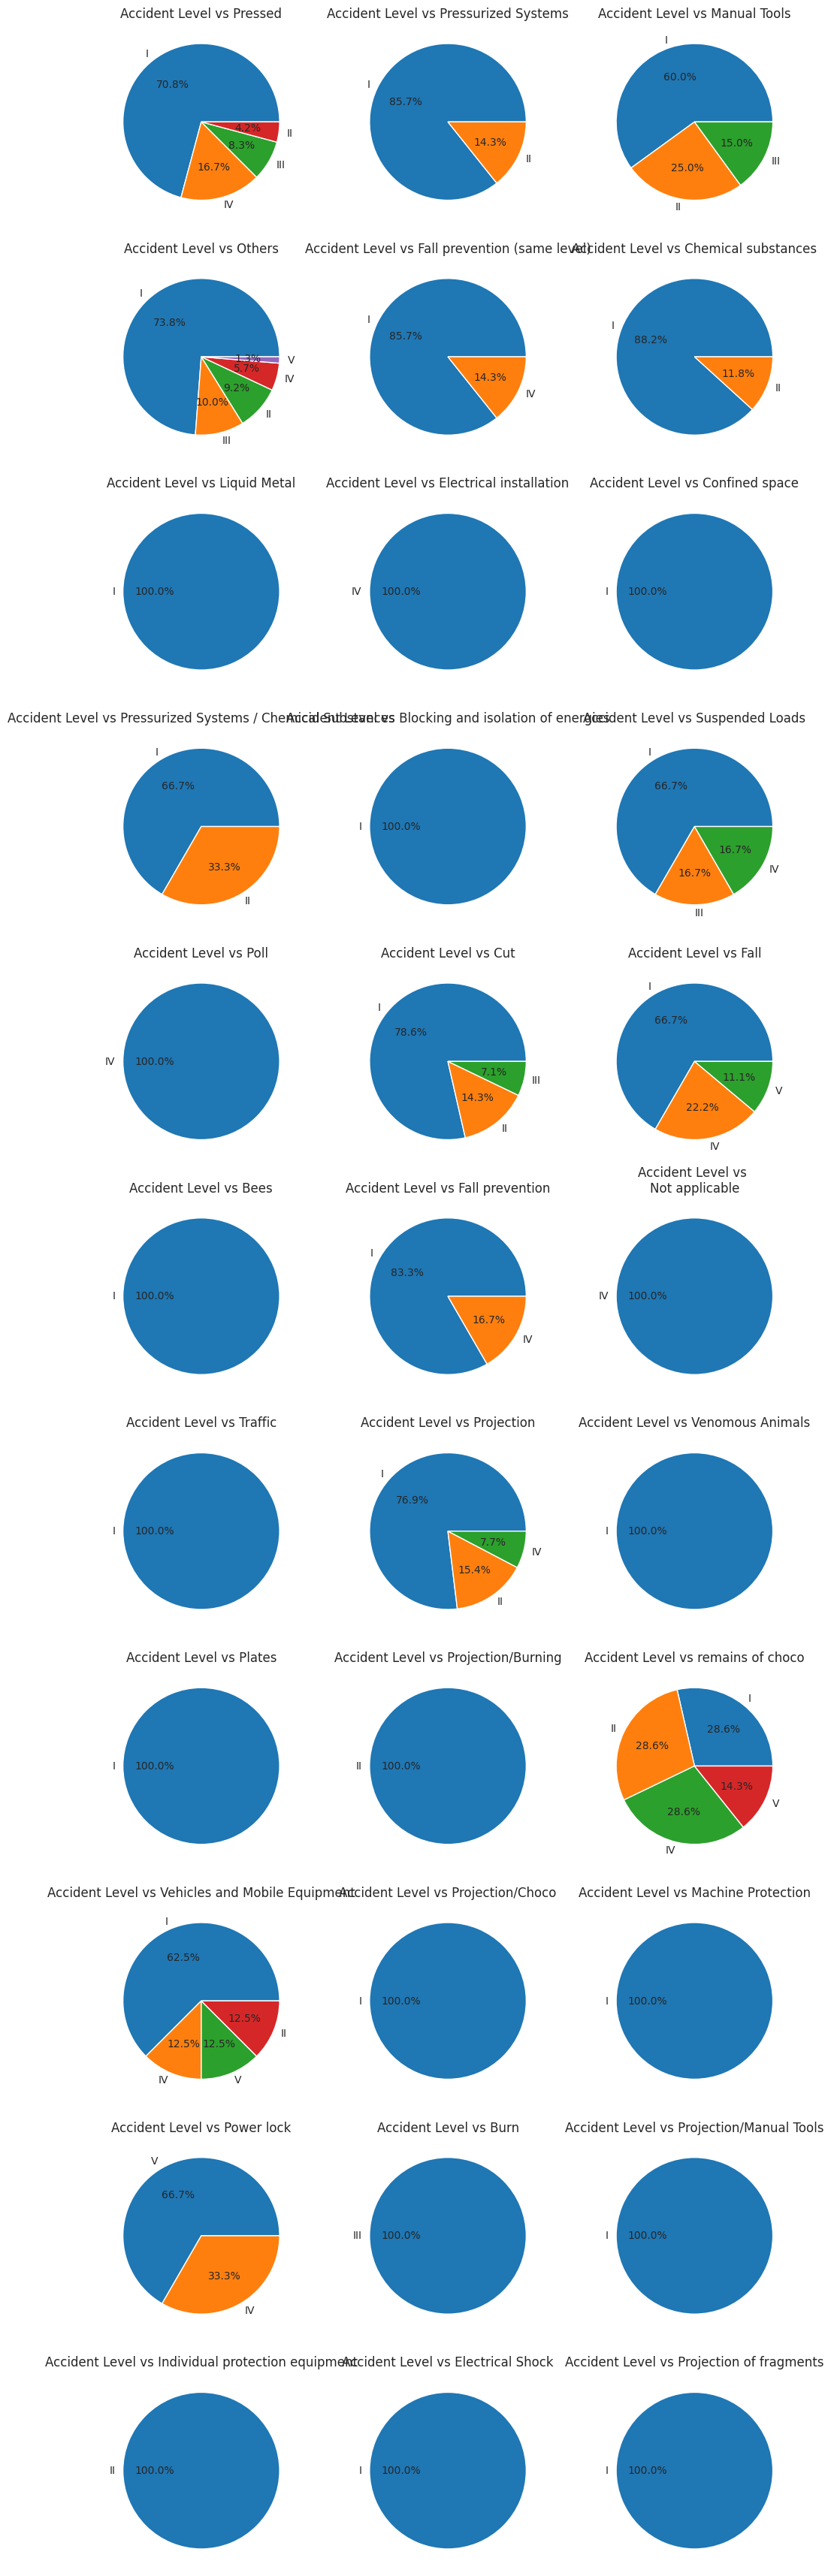

In [ ]:
plot_pieChartshowAllPiesForColumn(df_proc_1, 'Critical_Risk','Accident_Level', 3)

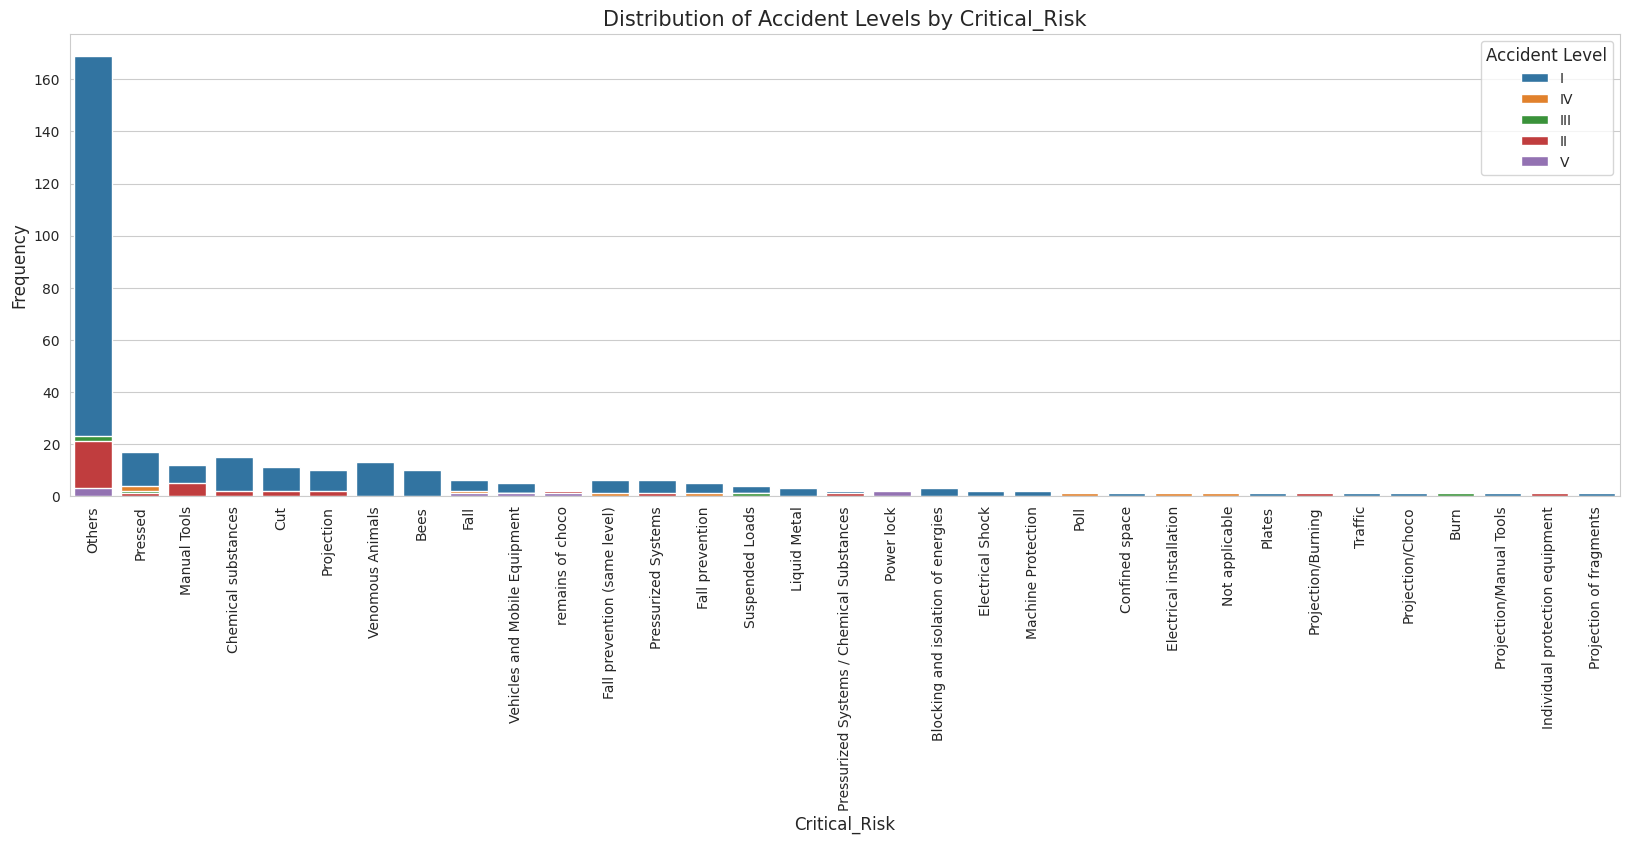

In [ ]:
plot_accident_levels(df_proc_1, 'Critical_Risk')

##### Accidents by Month

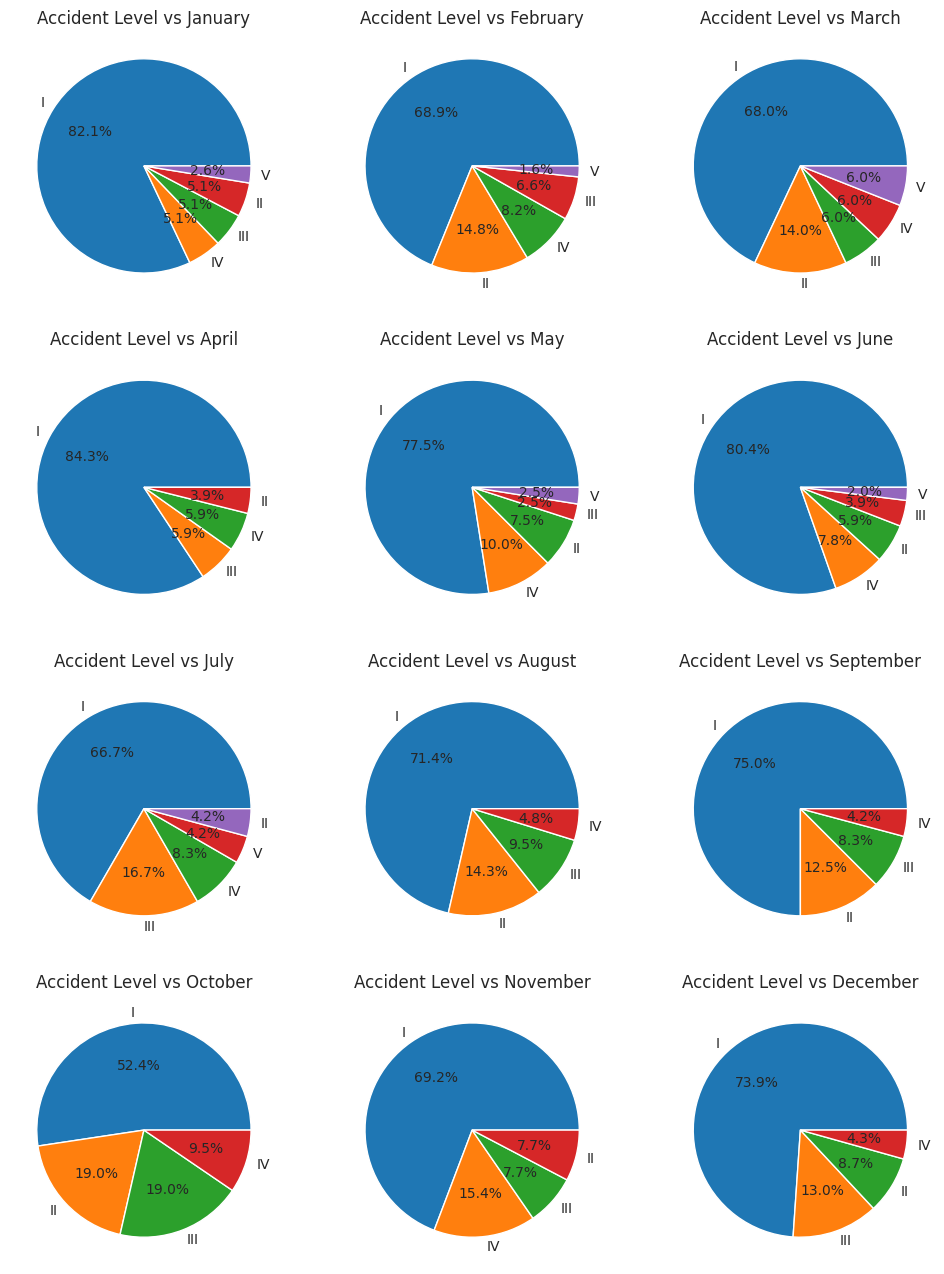

In [ ]:
plot_pieChartshowAllPiesForColumn(df_proc_1, 'Month','Accident_Level', 3)

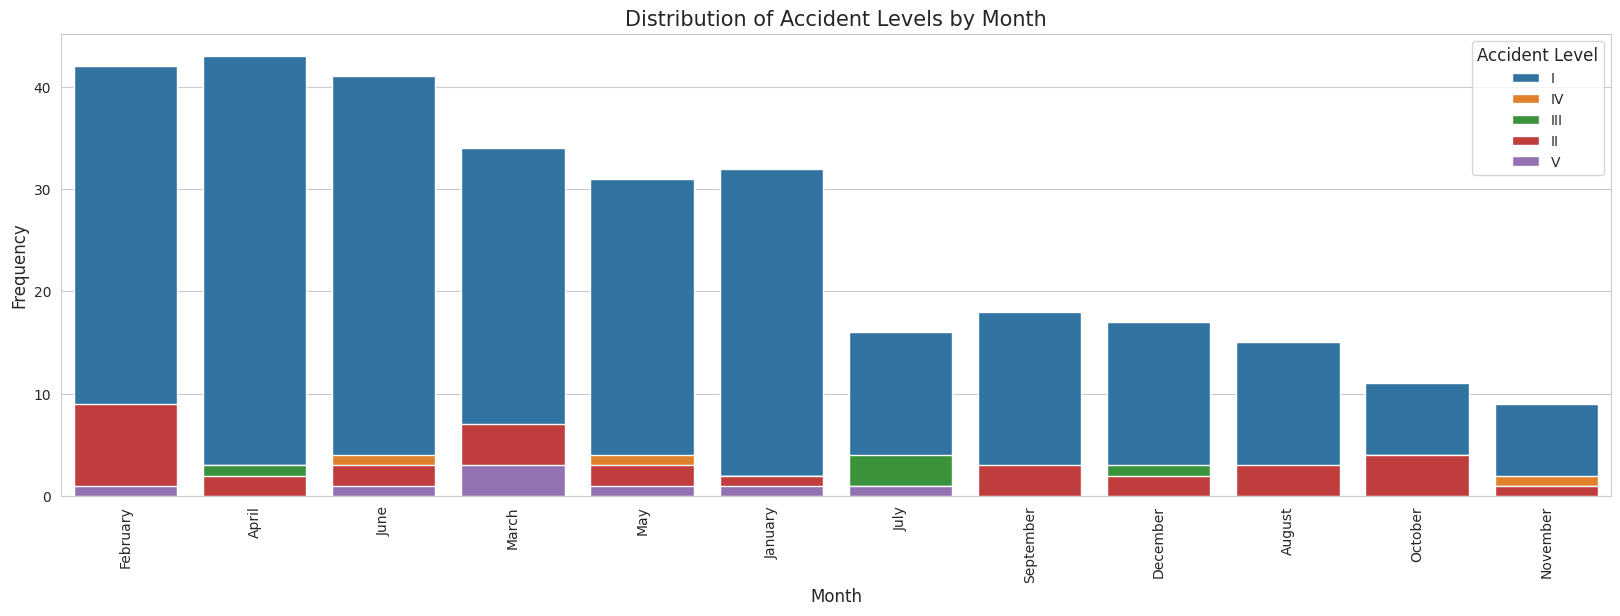

In [ ]:
plot_accident_levels(df_proc_1, 'Month')

##### Accidents by Weekday

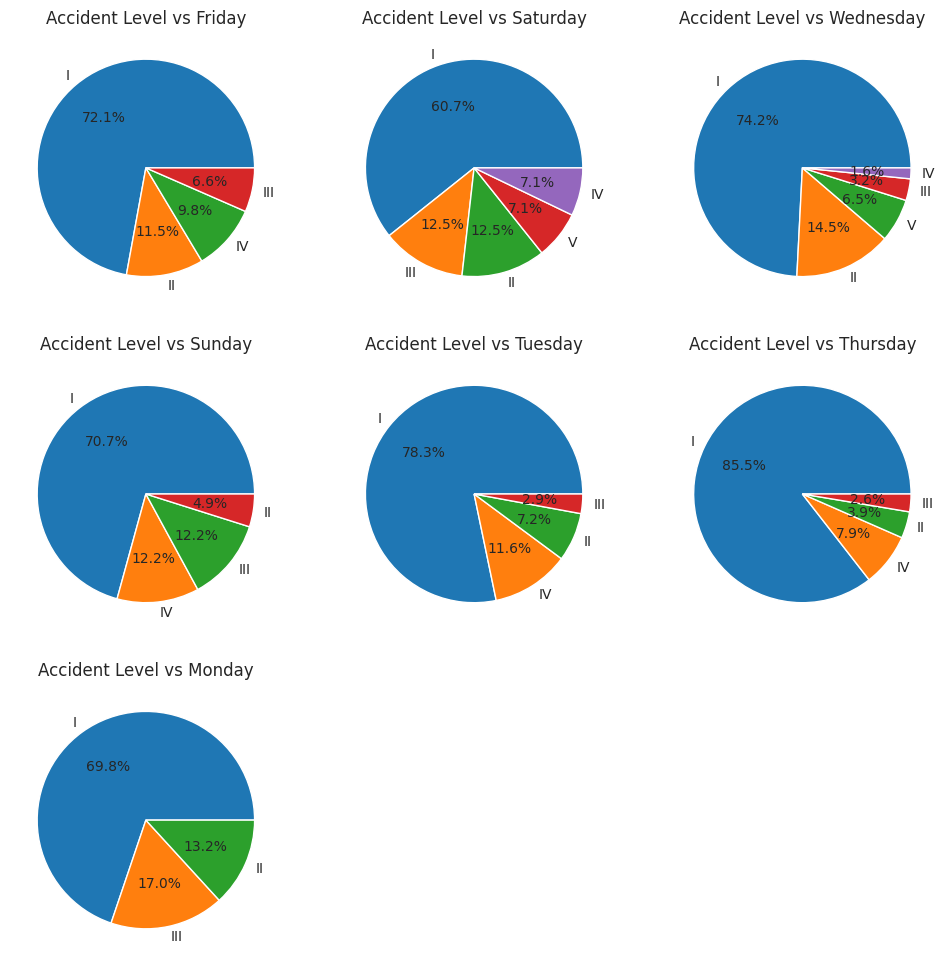

In [ ]:
plot_pieChartshowAllPiesForColumn(df_proc_1, 'Weekday','Accident_Level', 3)

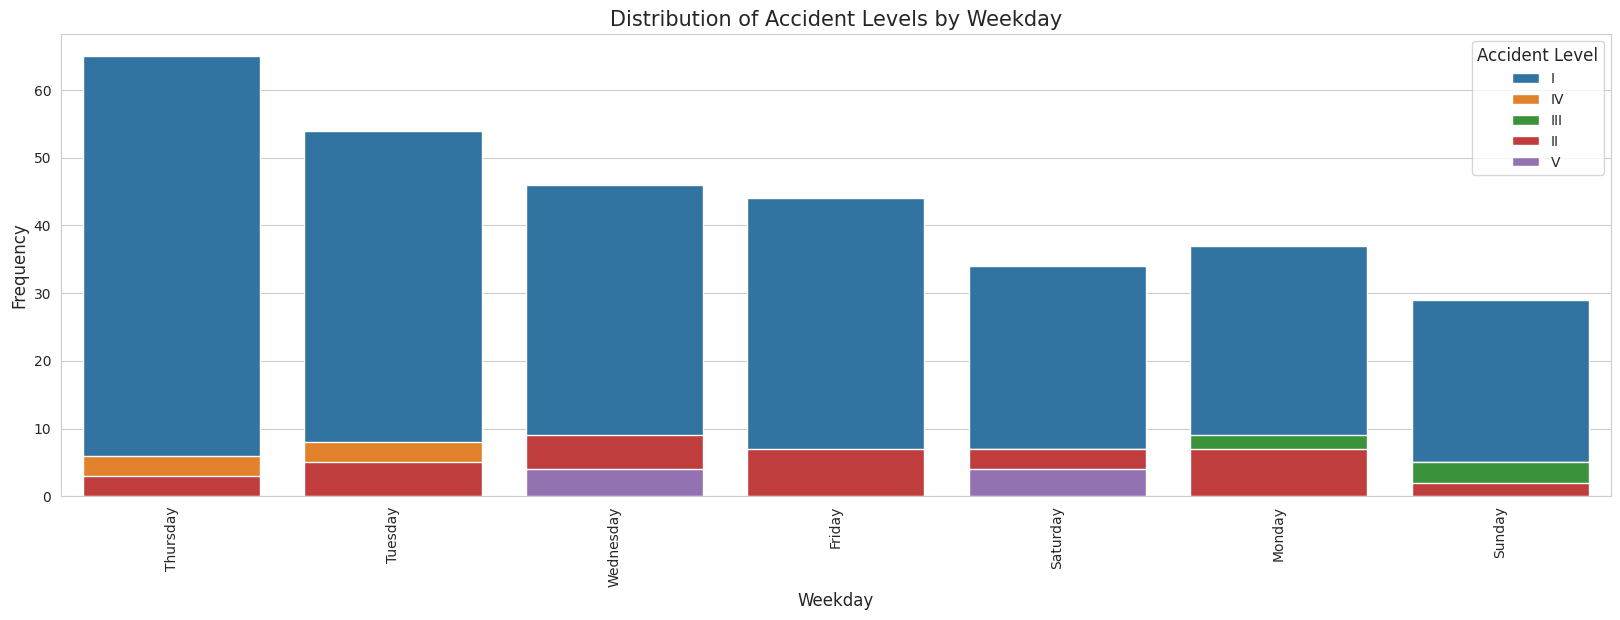

In [ ]:
plot_accident_levels(df_proc_1, 'Weekday')

#### **Relationship between Accident Level and Potential Accident Level**

Convert the ordinal levels of `Accident Level` and `Potential Accident Level` from Roman to integers.

In [ ]:
# Convert ordinal levels to numeric
df_proc_2 = df_proc_1.copy()

ordinal_mapping = {'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5, 'VI': 6}

df_proc_2['Accident_Level'] = df_proc_2['Accident_Level'].map(ordinal_mapping)
df_proc_2['Potential_Accident_Level'] = df_proc_2['Potential_Accident_Level'].map(ordinal_mapping)

# Print the unique values of Accident_Level and Potential_Accident_Level
unique_values(df_proc_2.loc[:, ['Accident_Level', 'Potential_Accident_Level']])

Accident_Level: [1 4 3 2 5]
-----------------------------------
Potential_Accident_Level: [4 3 1 2 5 6]
-----------------------------------


In [ ]:
pd.crosstab(df_proc_2['Accident_Level'], df_proc_2['Potential_Accident_Level'])

Potential_Accident_Level   1   2   3   4  5  6
Accident_Level                                
1                         45  88  89  78  9  0
2                          0   7  14  16  3  0
3                          0   0   3  26  2  0
4                          0   0   0  21  9  0
5                          0   0   0   0  7  1

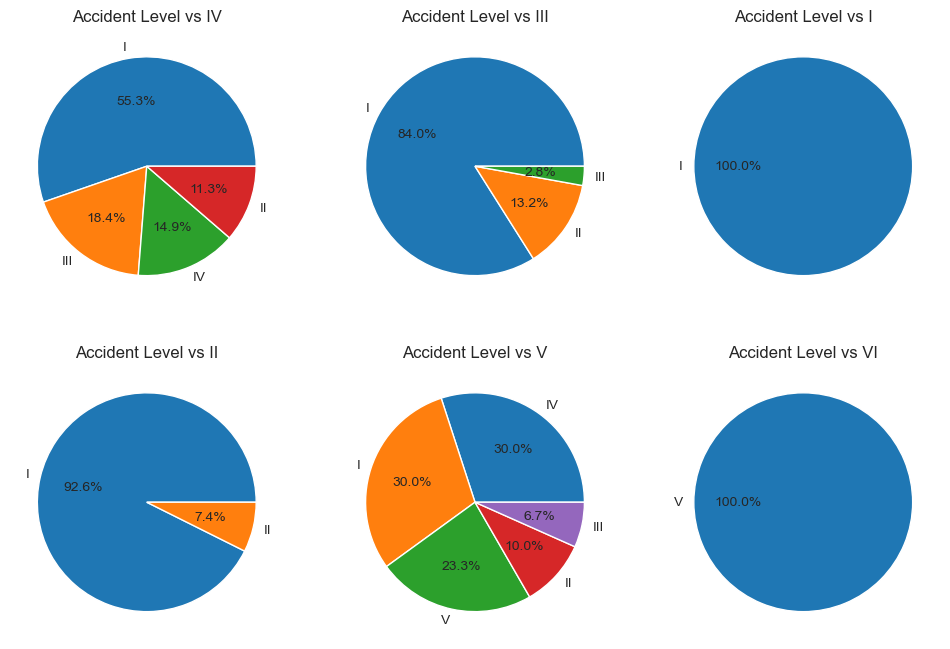

In [ ]:
plot_pieChartshowAllPiesForColumn(df_proc_1, 'Potential_Accident_Level','Accident_Level', 3)

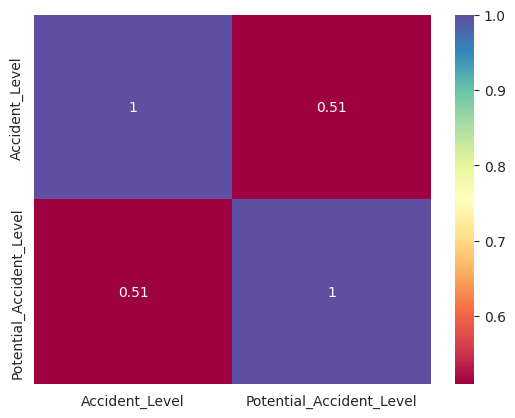

In [ ]:
# Visualizing a heatmap to show correlation between 'Accident Level' & 'Potential Accident Level'

sns.heatmap(df_proc_2[['Accident_Level','Potential_Accident_Level']].corr(),annot=True,cmap='Spectral');

In [ ]:
print('Between Accident_Level and Potential_Accident_Level:')

# Calculate the Pearson correlation coefficient for Accident_Level and Potential_Accident_Level
person_correlation = df_proc_2['Accident_Level'].corr(df_proc_2['Potential_Accident_Level'])
print(f'The Pearson correlation coefficient is {person_correlation:.2f}')

# Calculate the Spearman correlation coefficient for Accident_Level and Potential_Accident_Level
spearman_correlation = df_proc_2['Accident_Level'].corr(df_proc_2['Potential_Accident_Level'], method='spearman')
print(f'The Spearman correlation coefficient is {spearman_correlation:.2f}')

Between Accident_Level and Potential_Accident_Level:
The Pearson correlation coefficient is 0.51
The Spearman correlation coefficient is 0.50


In [ ]:
# finding the average accident level across industry sectors

df_proc_2.groupby('Industry_Sector')['Accident_Level'].mean()

Industry_Sector
Metals    1.380597
Mining    1.662447
Others    1.340426
Name: Accident_Level, dtype: float64

In [ ]:
# finding the average potential accident level across industry sectors

df_proc_2.groupby('Industry_Sector')['Potential_Accident_Level'].mean()

Industry_Sector
Metals    2.813433
Mining    3.430380
Others    1.765957
Name: Potential_Accident_Level, dtype: float64

The accident levels are more fatal in Mining industry.

**Observation and Inference:**
- Both correlation coefficients (0.51 for Pearson and 0.50 for Spearman) suggest a **_moderate positive relationship_** between `Accident_Level` and `Potential_Accident_Level`. This indicates that higher levels of accidents are likely associated with higher potential levels of accidents.
- The similarity in values (0.51 for Pearson and 0.50 for Spearman) suggests that the relationship is reasonably **_consistent across both linear and monotonic assessments_**. This consistency strengthens the reliability of the observed association.

**Given the requirement for this project, we would drop the column `Accident_Level` and consider `Potential_Accident_Level` as the target variable.**

#### **Setting the target column based on the observations**

In [ ]:
# targetColumn= "Accident_Level"
targetColumn= "Potential_Accident_Level"
notTargetColumn= "Accident_Level"

In [ ]:
# Drop the 'Potential Accident_Level' column
df_processed = df_proc_2.drop(columns=[notTargetColumn])
display(df_processed.sample(3))

Country  Location Industry_Sector  Potential_Accident_Level Gender  \
360  Country_01  Local_06          Metals                         2   Male   
312  Country_03  Local_10          Others                         2   Male   
4    Country_01  Local_04          Mining                         4   Male   

    Employee_Type Critical_Risk  \
360   Third Party        Others   
312      Employee        Others   
4     Third Party        Others   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Description  \
360                                                                                                                                                                                                                                                                                                                                                                                                                                The industrial cleaning worker Cristian was performing the cleaning activity of the gutter, striking with a walls of the same, to remove the solid solution that is formed. In that At the moment the operator's hands slide and impact on the edge of the gutter, causing a blow on the little finger of the left hand.   
312  On 05/02/2017, at 10:40 p.m., when performing geological mapping activity, the geologist Manoel da Silva accompanied by the geologists Luciano dos Santos and Dayme had to make the crossing to the other side of a fence barbed wire, known in the region as a goat. It is a fence that from the base up to about 60cm in height is made by rods interlaced horizontally and upwards made with little barbed wire barbed, around 15 to 20cm. I jumped on the fence, and still on the fence I managed to "sweep" the vegetation with the left foot but even so while supporting the foot on the ground a stump of approximately 10cm x 1cm came to break the sole of the boot and cause the perforation in the left foot at the height of the fingers.   
4                                                                                                                                                                                                                                                   Approximately at 11:45 a.m. in circumstances that the mechanics Anthony (group leader), Eduardo and Eric Fernández-injured-the three of the Company IMPROMEC, performed the removal of the pulley of the motor of the pump 3015 in the ZAF of Marcy. 27 cm / Length: 33 cm / Weight: 70 kg), as it was locked proceed to heating the pulley to loosen it, it comes out and falls from a distance of 1.06 meters high and hits the instep of the right foot of the worker, causing the injury described.   

        Month   Weekday  
360     April  Thursday  
312  February    Sunday  
4     January    Sunday

#### Encode the target variable using Ordinal Encoding

In [ ]:
df_processed[targetColumn].value_counts()

Potential_Accident_Level
4    141
3    106
2     95
1     45
5     30
6      1
Name: count, dtype: int64

Let us observe the single row having Potential_Accident_Level as 6

In [ ]:
# Display the row with 'Potential Accident Level' of 6
df_proc_2[df_proc_2[targetColumn] == 6]

Country  Location Industry_Sector  Accident_Level  \
304  Country_01  Local_03          Mining               5   

     Potential_Accident_Level Gender Employee_Type     Critical_Risk  \
304                         6   Male   Third Party  remains of choco   

                                                                                                                                                                                                                                                                                                                                                                                                     Description  \
304  During the process of loading drills in the Carmen pit of level 3450, the operator positions the basket of the anfo loader 186 equipment at a height of 3m from the floor to carry out the loading of the production drills; At this moment, a stone slab of 1.4x0.7x0.2 m is detached from the front of the pit, which is tilted and lodged inside the basket, trapping the right leg of the collaborator.   

       Month    Weekday  
304  January  Wednesday

In [ ]:
# Display other records having same 'Sector', 'Locality', 'Critical Risk' and 'Gender' as the record with 'Potential Accident Level' of 6
level6_sector = df_proc_2[df_proc_2[targetColumn] == 6]['Industry_Sector'].values[0]
level6_location = df_proc_2[df_proc_2[targetColumn] == 6]['Location'].values[0]
level6_risk = df_proc_2[df_proc_2[targetColumn] == 6]['Critical_Risk'].values[0]
level6_gender = df_proc_2[df_proc_2[targetColumn] == 6]['Gender'].values[0]


df_proc_2[(df_proc_2['Industry_Sector'] == level6_sector) & (df_proc_2['Location'] == level6_location) & (df_proc_2['Critical_Risk'] == level6_risk) & (df_proc_2['Gender'] == level6_gender)]

Country  Location Industry_Sector  Accident_Level  \
295  Country_01  Local_03          Mining               1   
304  Country_01  Local_03          Mining               5   
314  Country_01  Local_03          Mining               2   
338  Country_01  Local_03          Mining               2   

     Potential_Accident_Level Gender Employee_Type     Critical_Risk  \
295                         3   Male      Employee  remains of choco   
304                         6   Male   Third Party  remains of choco   
314                         5   Male      Employee  remains of choco   
338                         4   Male   Third Party  remains of choco   

                                                                                                                                                                                                                                                                                                                                                                                                     Description  \
295                            At level 3450, Tajo area 2; after completing the drilling of drills for loading; the operator removes the bit from the jumbo arm and walks towards the crew cabin; from the crown of the work a fragment of rock that passes through the cocada of the mesh of 3 "and impacts on its helmet and rebound hits the right shoulder of the operator, generating the described injury.   
304  During the process of loading drills in the Carmen pit of level 3450, the operator positions the basket of the anfo loader 186 equipment at a height of 3m from the floor to carry out the loading of the production drills; At this moment, a stone slab of 1.4x0.7x0.2 m is detached from the front of the pit, which is tilted and lodged inside the basket, trapping the right leg of the collaborator.   
314          In Level 2900 - OP 5 the worker performed the chuteo ore from the hopper to the second car, perceived a slip of water and mud through the hopper, decided to leave the platform and when he was already down the second rung of the ladder of access, the water increases and a fragment of rock slides and hits the back of the worker causing it to fall and hit the right forearm and left knee.   
338                                                                      In the area of ​​Lloclla 50 meters from the sub-station Nro 4, under circumstances that the worker was preparing to pick up the rope from the floor, several fragments of rock slide down the slope of the hill, one of the 5 cm fragments of Diameter approximately impacts the face of the worker producing the aforementioned injury   

        Month    Weekday  
295   January    Tuesday  
304   January  Wednesday  
314  February    Tuesday  
338  February     Monday

From visual analysis of the data, we would make the level 6 as 5 instead.

In [ ]:
# Change the level of 'Potential Accident Level' from 6 to 5 for the single row
df_processed['Potential_Accident_Level'] = df_processed['Potential_Accident_Level'].replace(6, 5)


The `Potential_Accident_Level` has inherent order representing increasing severity. Maintaining the numerical relationship is important for analysis. Hence we would proceed with **Ordinal Encoding**

In [ ]:
def ordinal_encoding(df, column, levels=None):
    if levels is None:
        levels = sorted(df[column].unique())

    # Create mapping dictionary
    mapping = {val: idx for idx, val in enumerate(levels)}

    # Apply mapping
    df[f'{column}_encoded'] = df[column].map(mapping)

    return df, mapping

In [ ]:
df_accidentLevel_encoded = df_processed.copy()

levels = [1, 2, 3, 4, 5]  # Define the order
df_accidentLevel_encoded, level_mapping = ordinal_encoding(df_accidentLevel_encoded, targetColumn, levels)

In [ ]:
print(f'Level Mapping: {level_mapping}')

Level Mapping: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}


In [ ]:
df_accidentLevel_encoded.drop(columns=[targetColumn], inplace=True)
df_accidentLevel_encoded.sample(3)

Country  Location Industry_Sector Gender Employee_Type  \
63   Country_02  Local_05          Metals   Male      Employee   
118  Country_01  Local_11          Others   Male      Employee   
412  Country_02  Local_02          Mining   Male      Employee   

           Critical_Risk  \
63   Chemical substances   
118               Others   
412              Pressed   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Description  \
63                                                                                                                                                                                                                                                                                                                                                                                                         The employee checked for acid leakage in the shipping area when he was hit by splashes of solution in his right hemiface.   
118  When an employee of MILPO Lima visited the facilities, when he was at level 2900, waiting for the personnel cage to go up to level 4070, drops of water fall from the ceiling from a height of 2.20 meters approximately, product of a slight filtration in the crown (sustained with shotcrete), a drop enters the right eye causing discomfort in the right eye. According to the employee, at the time of the accident the lenses had been removed to clean them, this happened after the visit to the interior of the mine.   
412                                                                                                                                                                                                                                                       After maintenance on Boltec 03 at level 285 GTS of Rampa XXX, the mechanic and operator of the equipment performed tests on the equipment magazine. When the magazine carousel was turned on, the operator had his left middle finger pressed against the equipment frame.   

     Month   Weekday  Potential_Accident_Level_encoded  
63   March    Monday                                 3  
118    May   Tuesday                                 1  
412   June  Thursday                                 2

In [ ]:
# rename column to Potential_Accident_Level
df_processed = df_accidentLevel_encoded.copy()
df_processed.rename(columns={f'{targetColumn}_encoded': targetColumn}, inplace=True)
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Country                   418 non-null    object
 1   Location                  418 non-null    object
 2   Industry_Sector           418 non-null    object
 3   Gender                    418 non-null    object
 4   Employee_Type             418 non-null    object
 5   Critical_Risk             418 non-null    object
 6   Description               418 non-null    object
 7   Month                     418 non-null    object
 8   Weekday                   418 non-null    object
 9   Potential_Accident_Level  418 non-null    int64 
dtypes: int64(1), object(9)
memory usage: 32.8+ KB


In [ ]:
df_NLP = df_processed.copy()
df_NLP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Country                   418 non-null    object
 1   Location                  418 non-null    object
 2   Industry_Sector           418 non-null    object
 3   Gender                    418 non-null    object
 4   Employee_Type             418 non-null    object
 5   Critical_Risk             418 non-null    object
 6   Description               418 non-null    object
 7   Month                     418 non-null    object
 8   Weekday                   418 non-null    object
 9   Potential_Accident_Level  418 non-null    int64 
dtypes: int64(1), object(9)
memory usage: 32.8+ KB


## **Feature Selection for Basic Machine Learning Model**
We already have dropped columns like `Date` which we feel would not contribute to model predictions, and `Accident_Level` as it was similar to `Potential_Accident_level`.
From our EDA above, we would further drop columns:
- `Country` - It has been specified that we are presented with data from Brazil, and not from other countries.
- `Critical_Risk` - This is just a classification of the description column.

Additionally, since we would be training a basic machine learning model, let us drop the `Description` for time being.


In [ ]:
# Drop the columns 'Country', 'Critical_Risk' and 'Description'
df_basicModel_1 = df_processed.drop(columns=['Country', 'Critical_Risk', 'Description'])
df_basicModel_1.info() # Will be using this dataframe further for training the Basic ML Model


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Location         418 non-null    object
 1   Industry_Sector  418 non-null    object
 2   Accident_Level   418 non-null    int64 
 3   Gender           418 non-null    object
 4   Employee_Type    418 non-null    object
 5   Month            418 non-null    object
 6   Weekday          418 non-null    object
dtypes: int64(1), object(6)
memory usage: 23.0+ KB


### Encode the categorical features

#### Location

In [ ]:
print(df_basicModel_1['Location'].unique())

['Local_01' 'Local_02' 'Local_03' 'Local_04' 'Local_05' 'Local_06'
 'Local_07' 'Local_08' 'Local_10' 'Local_09' 'Local_11' 'Local_12']


For locations we have observed -
1. Locations are anonymized but numbered sequentially from `Local_01` to `Local_12`
2. Some locations have significantly higher accident rates than others and the distribution is highly skewed.

We would proceed with **Frequency encoding** for `Location`.

In [ ]:
def frequency_encoding(df, column):
    freq_map = df[column].value_counts(normalize=True).to_dict()
    df[f'{column}_freq'] = df[column].map(freq_map)

In [ ]:
df_basic_locationFreq = df_basicModel_1.copy()
# Choose either frequency or label encoding based on your needs
frequency_encoding(df_basic_locationFreq, 'Location')

In [ ]:
df_basic_locationFreq.drop(columns=['Location'], inplace=True)
df_basic_locationFreq.head(3)

Industry_Sector  Accident_Level Gender         Employee_Type    Month  \
0          Mining               1   Male           Third Party  January   
1          Mining               1   Male              Employee  January   
2          Mining               1   Male  Third Party (Remote)  January   

     Weekday  Location_freq  
0     Friday       0.133971  
1   Saturday       0.055024  
2  Wednesday       0.212919

#### Industry_sector

In [ ]:
print(df_basicModel_1['Industry_Sector'].unique())

['Mining' 'Metals' 'Others']


Industry sector has only 3 categories and have no inherent ordering. Hence lets proceed with One-Hot encoding.

In [ ]:
def onehot_encoding(df, column):
    # Create dummy variables
    dummies = pd.get_dummies(df[column], prefix=column)

    # Add dummy columns to original dataframe
    df = pd.concat([df, dummies], axis=1)

    return df

In [ ]:
df_basic_industrySector = df_basic_locationFreq.copy()
df_basic_industrySector = onehot_encoding(df_basic_industrySector, 'Industry_Sector')

In [ ]:
df_basic_industrySector.drop(columns=['Industry_Sector'], inplace=True)
df_basic_industrySector.head(3)

Accident_Level Gender         Employee_Type    Month    Weekday  \
0               1   Male           Third Party  January     Friday   
1               1   Male              Employee  January   Saturday   
2               1   Male  Third Party (Remote)  January  Wednesday   

   Location_freq  Industry_Sector_Metals  Industry_Sector_Mining  \
0       0.133971                   False                    True   
1       0.055024                   False                    True   
2       0.212919                   False                    True   

   Industry_Sector_Others  
0                   False  
1                   False  
2                   False

#### Employee_Type

In [ ]:
print(df_basicModel_1['Employee_Type'].unique())

['Third Party' 'Employee' 'Third Party (Remote)']


Employee Type has only 3 categories and have no inherent ordering. Hence lets proceed with One-Hot encoding. However before that let us change the values to single words as follows:
- `Employee` remains as is.
- `Third Party` to `Contractor`
- `Third Party (Remote)` to `Contractor_Remote`


In [ ]:
# Change the values of 'Employee_Type' to 'Employee', 'Contractor' and 'Contractor_Remote'
df_basic_employeeType = df_basic_industrySector.copy()

df_basic_employeeType['Employee_Type'] = df_basic_employeeType['Employee_Type'].replace({
    'Third Party':'Contractor',
    'Third Party (Remote)':'Contractor_Remote'
})

df_basic_employeeType = onehot_encoding(df_basic_employeeType, 'Employee_Type')

In [ ]:
df_basic_employeeType.drop(columns=['Employee_Type'], inplace=True)
df_basic_employeeType.head(3)

Accident_Level Gender    Month    Weekday  Location_freq  \
0               1   Male  January     Friday       0.133971   
1               1   Male  January   Saturday       0.055024   
2               1   Male  January  Wednesday       0.212919   

   Industry_Sector_Metals  Industry_Sector_Mining  Industry_Sector_Others  \
0                   False                    True                   False   
1                   False                    True                   False   
2                   False                    True                   False   

   Employee_Type_Contractor  Employee_Type_Contractor_Remote  \
0                      True                            False   
1                     False                            False   
2                     False                             True   

   Employee_Type_Employee  
0                   False  
1                    True  
2                   False

#### Gender

For Gender we would proceed with Binary Encoding as it has only 2 values.

In [ ]:
def binary_encoding(df, column, positive_class):
    df[f'{column}_binary'] = (df[column] == positive_class).astype(int)
    return df

In [ ]:
df_basic_gender = df_basic_employeeType.copy()
df_basic_gender = binary_encoding(df_basic_gender, 'Gender', positive_class='Female')

In [ ]:
df_basic_gender.drop(columns=['Gender'], inplace=True)
df_basic_gender

Accident_Level    Month    Weekday  Location_freq  \
0                 1  January     Friday       0.133971   
1                 1  January   Saturday       0.055024   
2                 1  January  Wednesday       0.212919   
3                 1  January     Friday       0.131579   
4                 4  January     Sunday       0.131579   
..              ...      ...        ...            ...   
413               1     July    Tuesday       0.131579   
414               1     July    Tuesday       0.212919   
415               1     July  Wednesday       0.004785   
416               1     July   Thursday       0.141148   
417               1     July     Sunday       0.131579   

     Industry_Sector_Metals  Industry_Sector_Mining  Industry_Sector_Others  \
0                     False                    True                   False   
1                     False                    True                   False   
2                     False                    True                   False   
3                     False                    True                   False   
4                     False                    True                   False   
..                      ...                     ...                     ...   
413                   False                    True                   False   
414                   False                    True                   False   
415                    True                   False                   False   
416                    True                   False                   False   
417                   False                    True                   False   

     Employee_Type_Contractor  Employee_Type_Contractor_Remote  \
0                        True                            False   
1                       False                            False   
2                       False                             True   
3                        True                            False   
4                        True                            False   
..                        ...                              ...   
413                      True                            False   
414                     False                            False   
415                     False                            False   
416                     False                            False   
417                      True                            False   

     Employee_Type_Employee  Gender_binary  
0                     False              0  
1                      True              0  
2                     False              0  
3                     False              0  
4                     False              0  
..                      ...            ...  
413                   False              0  
414                    True              1  
415                    True              0  
416                    True              0  
417                   False              1  

[418 rows x 11 columns]

#### Month and Weekday

For `Month` and `Weekday` we would proceed with **Cyclical Encoding** as they represent time data.  December is as close to January as November, and Sunday is as close to Monday as Saturday. Cyclical encoding would preserve this cyclical nature of data.

In [ ]:
def cyclical_encoding(df, column, max_val):
    # Convert to normalized values between 0 and 2π
    df[f'{column}_sin'] = np.sin(2 * np.pi * df[column].astype(int) / max_val)
    df[f'{column}_cos'] = np.cos(2 * np.pi * df[column].astype(int) / max_val)

    return df

# Define the dictionary for cyclical encoding
MONTH_DICT = {month: idx+1 for idx, month in
              enumerate(['January', 'February', 'March', 'April',
                        'May', 'June', 'July', 'August', 'September',
                        'October', 'November', 'December'])}

WEEKDAY_DICT = {day: idx+1 for idx, day in
                enumerate(['Monday', 'Tuesday', 'Wednesday', 'Thursday',
                          'Friday', 'Saturday', 'Sunday'])}

In [ ]:
# Convert months to numbers using the MONTH_DICT
df_basic_month = df_basic_gender.copy()

df_basic_month['Month_Num'] = df_basic_month['Month'].map(MONTH_DICT)
df_basic_month = cyclical_encoding(df_basic_month, 'Month_Num', max_val=12)

In [ ]:
df_basic_month.drop(columns=['Month', 'Month_Num'], inplace=True)
df_basic_month.head(3)

Accident_Level    Weekday  Location_freq  Industry_Sector_Metals  \
0               1     Friday       0.133971                   False   
1               1   Saturday       0.055024                   False   
2               1  Wednesday       0.212919                   False   

   Industry_Sector_Mining  Industry_Sector_Others  Employee_Type_Contractor  \
0                    True                   False                      True   
1                    True                   False                     False   
2                    True                   False                     False   

   Employee_Type_Contractor_Remote  Employee_Type_Employee  Gender_binary  \
0                            False                   False              0   
1                            False                    True              0   
2                             True                   False              0   

   Month_Num_sin  Month_Num_cos  
0            0.5       0.866025  
1            0.5       0.866025  
2            0.5       0.866025

In [ ]:
# Convert weekdays to numbers using the WEEKDAY_DICT
df_basic_weekday = df_basic_month.copy()

df_basic_weekday['Weekday_Num'] = df_basic_weekday['Weekday'].map(WEEKDAY_DICT)
df_basic_weekday = cyclical_encoding(df_basic_weekday, 'Weekday_Num', max_val=7)

In [ ]:
df_basic_weekday.drop(columns=['Weekday', 'Weekday_Num'], inplace=True)
df_basic_weekday.head(3)

Accident_Level  Location_freq  Industry_Sector_Metals  \
0               1       0.133971                   False   
1               1       0.055024                   False   
2               1       0.212919                   False   

   Industry_Sector_Mining  Industry_Sector_Others  Employee_Type_Contractor  \
0                    True                   False                      True   
1                    True                   False                     False   
2                    True                   False                     False   

   Employee_Type_Contractor_Remote  Employee_Type_Employee  Gender_binary  \
0                            False                   False              0   
1                            False                    True              0   
2                             True                   False              0   

   Month_Num_sin  Month_Num_cos  Weekday_Num_sin  Weekday_Num_cos  
0            0.5       0.866025        -0.974928        -0.222521  
1            0.5       0.866025        -0.781831         0.623490  
2            0.5       0.866025         0.433884        -0.900969

In [ ]:
# Copy the data into a new dataframe
df_basicModel_2 = df_basic_weekday.copy()
df_basicModel_2.info()

df_processed = df_basic_weekday.copy()
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Location_freq                    418 non-null    float64
 1   Industry_Sector_Metals           418 non-null    bool   
 2   Industry_Sector_Mining           418 non-null    bool   
 3   Industry_Sector_Others           418 non-null    bool   
 4   Employee_Type_Contractor         418 non-null    bool   
 5   Employee_Type_Contractor_Remote  418 non-null    bool   
 6   Employee_Type_Employee           418 non-null    bool   
 7   Gender_binary                    418 non-null    int32  
 8   Month_Num_sin                    418 non-null    float64
 9   Month_Num_cos                    418 non-null    float64
 10  Weekday_Num_sin                  418 non-null    float64
 11  Weekday_Num_cos                  418 non-null    float64
 12  Accident_Level_encoded

### Split the features into X and Y, and further in train, validation and test

In [ ]:
# Split the dataframe in X and Y
targetColumn = targetColumn+'_encoded'
X = df_basicModel_2.drop(columns=[targetColumn])
y = df_basicModel_2[targetColumn]

In [ ]:
# Split the data into train, validation and test sets ensuring we have representative samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Print the shape of the train, validation and test sets
print(f'Train set: {X_train.shape[0]} rows and {X_train.shape[1]} columns')
print(f'Validation set: {X_val.shape[0]} rows and {X_val.shape[1]} columns')
print(f'Test set: {X_test.shape[0]} rows and {X_test.shape[1]} columns')

Train set: 267 rows and 12 columns
Validation set: 67 rows and 12 columns
Test set: 84 rows and 12 columns


### Upsampling the minority class.

In [ ]:
y_train.value_counts(normalize=True)

Accident_Level_encoded
0    0.737828
1    0.097378
2    0.074906
3    0.071161
4    0.018727
Name: proportion, dtype: float64

We have seen very low numbers of the Accident levels 1 - 4. Let us up-sample these categories.

In [ ]:
# Upsample the minority classes in the Accident_Level - 3, 4 and 5 - in the training set
from imblearn.over_sampling import SMOTE

majority_class_count = y_train.value_counts().max()
desired_ratios = {1: 0.5, 2: 0.5, 3: 0.5, 4: 0.5}
sampling_strategy = {cls: int(majority_class_count * ratio) for cls, ratio in desired_ratios.items()}

# Find the minimum number of samples in the minority classes
minority_class_counts = y_train.value_counts()[list(desired_ratios.keys())]
min_samples = minority_class_counts.min()

# Set the k_neighbors parameter to the minimum number of samples in the minority classes minus 1
smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=min_samples - 1, random_state=42)

# Upsample the minority classes in the training set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print the shape of the upsampled training set
print(f'Train set: {X_train_resampled.shape[0]} rows and {X_train_resampled.shape[1]} columns')

# Print the value counts of the target variable in the upsampled training set
y_train_resampled.value_counts(normalize=True)


Train set: 589 rows and 12 columns


Accident_Level_encoded
0    0.334465
3    0.166384
2    0.166384
1    0.166384
4    0.166384
Name: proportion, dtype: float64

## **NLP Data Preprocessing**

### Performing word cloud to identify the most frequent words for each industry.

In [ ]:
# Importing WordCloud and STOPWORDS
import wordcloud
from wordcloud import WordCloud, STOPWORDS

In [ ]:
#To store the most frequent words per industry
frequent_keywords_per_industry=[]

In [ ]:
def get_cloud_for_level(df_wc,descriptionFieldName, columnName,value):
  comment_words = ''
  stopwords = set(STOPWORDS) #stop words to not be considered by the word cloud
  #initalize
  wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            stopwords = stopwords,
            min_font_size = 10)

  # iterate through the description column
  for val in df_wc[df_wc[columnName]==value][descriptionFieldName]:

      # typecaste each val to string
      val = str(val)

      # split the value
      tokens = val.split()

      # Converts each token into lowercase
      for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      #join all the tokens to be given as input to word cloud
      comment_words += " ".join(tokens)+" "

      wordcloud =wordcloud.generate(comment_words)

  # plot the WordCloud image
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.title('Word Cloud for Accident Level '+str(value))
  print("\n")
  plt.show()
  #get the top 10 words based on frquency
  top_keywords = sorted(wordcloud.words_.items(), key=lambda x: x[1], reverse=True)[:10]
  #return the top 10 words
  return ",".join (word for word, freq in top_keywords)

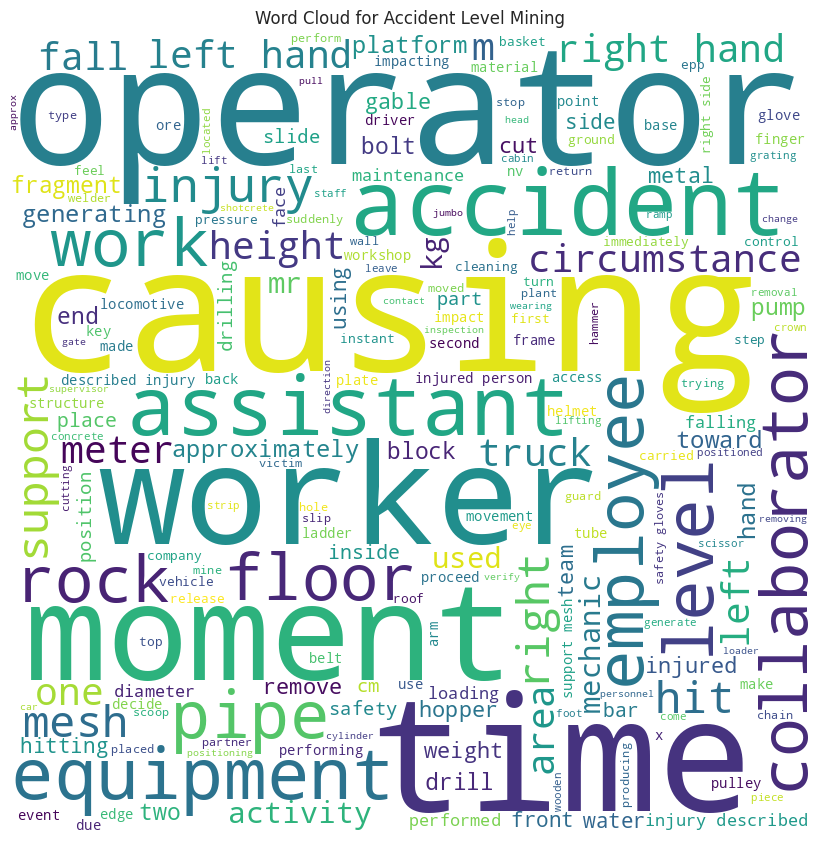

In [ ]:
#For Mining
frequent_keywords_per_industry.append(['Mining',get_cloud_for_level(df_NLP,"Description", "Industry_Sector","Mining")])

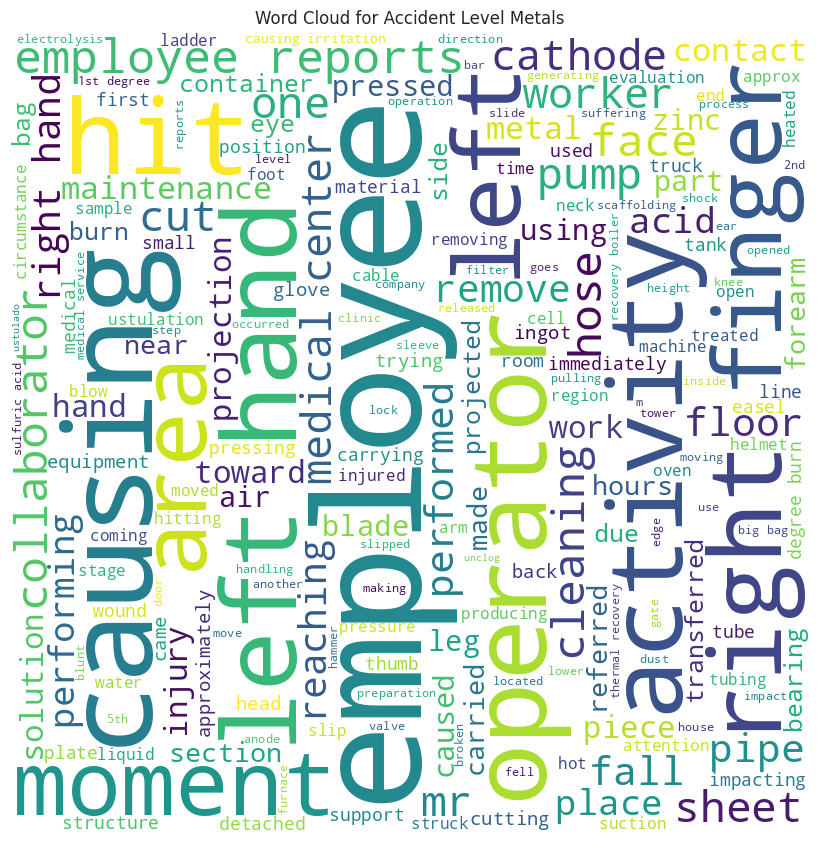

In [ ]:
#For Metal
frequent_keywords_per_industry.append(['Metals',get_cloud_for_level(df_NLP,"Description", "Industry_Sector","Metals")])

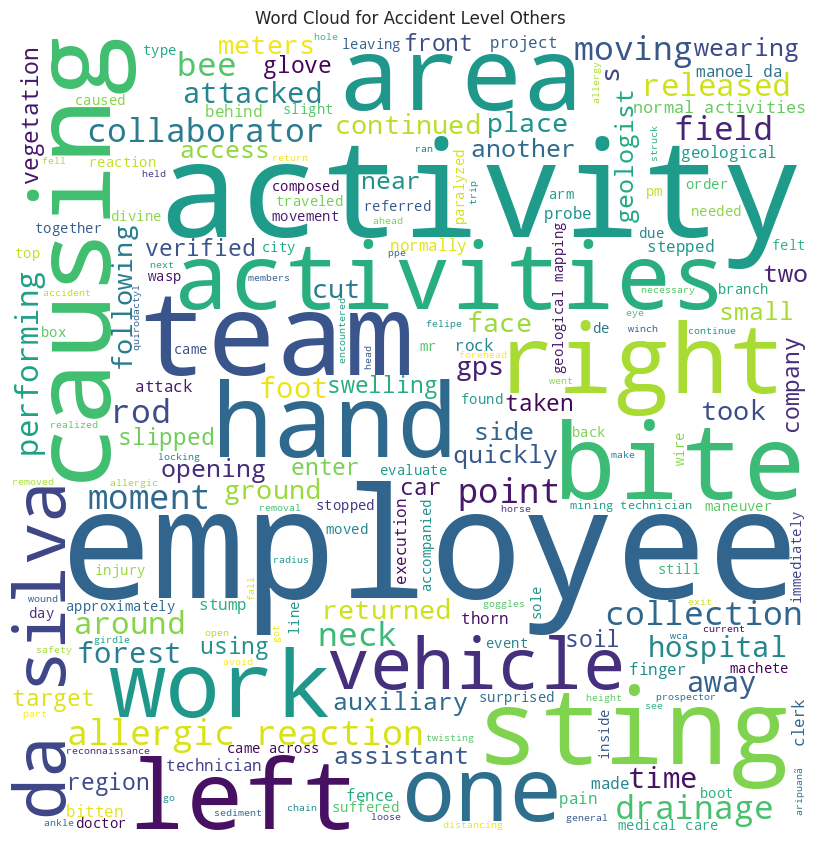

In [ ]:
#other industires
frequent_keywords_per_industry.append(['Others',get_cloud_for_level(df_NLP,"Description", "Industry_Sector","Others")])

In [ ]:
df_freq_keywords= pd.DataFrame (frequent_keywords_per_industry, columns=['Industry','KeyWords'])

In [ ]:
df_freq_keywords.head(3)

Industry  \
0   Mining   
1   Metals   
2   Others   

                                                                      KeyWords  
0  causing,operator,time,worker,moment,accident,assistant,equipment,level,work  
1      employee,causing,operator,hit,activity,left hand,right,finger,left,area  
2               employee,activity,team,causing,sting,bite,area,hand,left,right

The above are the most common keywords used from the different industries. We would use these words to up-scale our data further for the minority categories.

### Combine all features into a Sentence
Let us combine the other features into Sentence in a new column. This column will later be prefixed to the `Description` column to give more context.

In [ ]:
# Form a combined string with other columns and prefix it into the Description column
df_combinedDesc_orig = df_processed.copy()

# Update Employee_Type values
df_combinedDesc_orig['Employee_Type'] = df_combinedDesc_orig['Employee_Type'].replace({
    'Third Party': 'Contractor',
    'Third Party (Remote)': 'Remote Contractor'
})

df_combinedDesc_orig['Location'] = df_combinedDesc_orig['Location'].replace({
    'Local_01': 'one',
    'Local_02': 'two',
    'Local_03': 'three',
    'Local_04': 'four',
    'Local_05': 'five',
    'Local_06': 'six',
    'Local_07': 'seven',
    'Local_08': 'eight',
    'Local_09': 'nine',
    'Local_10': 'ten',
    'Local_11': 'eleven',
    'Local_12': 'twelve'
})

df_combinedDesc_orig['Combined_Features_Text'] = (
    'This incident happened in the ' + df_combinedDesc_orig['Industry_Sector'] + ' industry, in location '
    + df_combinedDesc_orig['Location'] + ', on a ' + df_combinedDesc_orig['Weekday'] + ' in the month of ' + df_combinedDesc_orig['Month']
    + ', with a ' + df_combinedDesc_orig['Gender'] + ' person who is a ' + df_combinedDesc_orig['Employee_Type'] + ' in the company.'
    + ' The risk was caused by ' + df_combinedDesc_orig['Critical_Risk'] + '. The detailed description is as follows: '
)

# Drop all columns except Description and Combined_Description
df_combinedDesc_orig.drop(columns=['Country', 'Location', 'Industry_Sector', 'Gender', 'Employee_Type', 'Critical_Risk', 'Month', 'Weekday'], inplace=True)
df_combinedDesc_orig.sample(3)

df_combinedDesc_orig.sample(3)

Description  \
370  On 04/19/2017, the employee de Lima da Silva was composing the team of opening of bite to survey of IP. The team consisted of one mining technician and three assistants. When was moving in the bite he touched his left foot on a stump of Tucum that was on the ground covered with dry leaves of vegetation near drainage. When he felt the thorn piercing on his foot, he told the mining technician what had happened and the teammate removed the thorn that pierced the top of the boot. After removal of the spine the foot was washed and it was verified that there was no other injury. After the event the technician waxed the activity and returned to the city of Porangatu / GO. It was not necessary to take the employee to the health unit.   
103                                                                                                                          The injured worker begins the work of presenting the support mesh cloth on the floor, making an initial cut in the mesh of a section of 0.3 m x 2.0 m for the ponchos, originating in the remaining mesh wicks (tips with prongs) protruding. When trying to make a second mesh cut, it is positioned at the edge of the remaining mesh with wicks to prevent them from curling, at which point it tries take your shear and remove the right foot of the mesh causing the mesh to roll up and embed a wick (tip with poles) through the left boot causing the injury. At the time of the accident the worker was wearing safety boots.   
81                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    When it opens the suction valve of the 420-BO-01 acid pump, the cable of the same pump comes loose by pressing the 5th finger of the employee's left hand against the tubing, causing a fracture in the distal phalanx. Photos   

     Potential_Accident_Level  \
370                         3   
103                         1   
81                          3   

                                                                                                                                                                                                                     Combined_Features_Text  
370    This incident happened in the Others industry, in location ten, on a Wednesday in the month of April, with a Male person who is a Contractor in the company. The risk was caused by Others. The detailed description is as follows:   
103       This incident happened in the Mining industry, in location one, on a Saturday in the month of April, with a Male person who is a Employee in the company. The risk was caused by Others. The detailed description is as follows:   
81   This incident happened in the Metals industry, in location nine, on a Monday in the month of April, with a Male person who is a Employee in the company. The risk was caused by Manual Tools. The detailed description is as follows:

### Split the data into training, validation and testing

In [ ]:
# Split the dataframe in X and Y
X = df_combinedDesc_orig.drop(columns=[targetColumn])
y = df_combinedDesc_orig[targetColumn]

In [ ]:
# Split the data into train, validation and test sets ensuring we have representative samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Print the shape of the train, validation and test sets
print(f'Train set: {X_train.shape[0]} rows and {X_train.shape[1]} columns')
print(f'Validation set: {X_val.shape[0]} rows and {X_val.shape[1]} columns')
print(f'Test set: {X_test.shape[0]} rows and {X_test.shape[1]} columns')

Train set: 267 rows and 2 columns
Validation set: 67 rows and 2 columns
Test set: 84 rows and 2 columns


### Data augmentation for minority categories

In [ ]:
# Function to augment data for the specified column
def augment_dataframe(orig_df, columnToAugment, level, augmentation_function, augmentation_percent=100):
    print (f'Original Dataframe shape: {orig_df.shape}')

    aug_rows_condition = (orig_df['is_augmented'].fillna('N') == 'N') if 'is_augmented' in orig_df.columns else True

    # Filter the original DataFrame based on the specified level and is_augmented column is 'N' or not exists
    df_level = orig_df[
        (orig_df[targetColumn] == level)
        & aug_rows_condition
    ]
    print(f'Shape of selected data: {df_level.shape}')

    # Number of augmentations per row
    if augmentation_percent >= 100:
        n_augmentations = int(augmentation_percent / 100)
    else:
        # Select randomly given percentage of rows to augment
        no_of_sample_rows = int(df_level.shape[0] * augmentation_percent / 100)
        df_level = df_level.sample(no_of_sample_rows)
        # Augment all selected rows once
        n_augmentations = 1

    print(f'Number of augmentations: {n_augmentations}')

    augmented_data = []
    for _, row in df_level.iterrows():
        original_sentence = row[columnToAugment]
        for _ in range(n_augmentations):
            augmented_sentence = augmentation_function(original_sentence)
            augmented_row = row.copy()
            augmented_row[columnToAugment] = augmented_sentence
            # augmented_row[f'Description'] = augmented_sentence
            augmented_row['is_augmented'] = 'Y'
            augmented_data.append(augmented_row)

    # Create a DataFrame with the augmented data
    df_augmented = pd.DataFrame(augmented_data)

    print(f'Augmented Dataframe shape: {df_augmented.shape}')

    # Add the original data with is_augmented column set to 'N'. If column has been augmented before, keep the is_augmented column as 'Y'
    # df_tmp = df.copy()
    # df_tmp['is_augmented'] = df_tmp.get('is_augmented', 'N')

    # Combine the original and augmented data
    orig_df = pd.concat([orig_df, df_augmented], ignore_index=True)

    print (f'Updated Original Dataframe shape: {orig_df.shape}')
    print(orig_df[targetColumn].value_counts())

    return orig_df


In [ ]:
# Combined the split dataframes X_train and y_train into a single dataframe
df_combinedDesc_orig_train = pd.concat([X_train, y_train], axis=1)

# Distribution of the target variable
df_combinedDesc_orig_train[targetColumn].value_counts()

Potential_Accident_Level
3    89
2    68
1    61
0    29
4    20
Name: count, dtype: int64

Let us augment the data for the levels 0 and 4. We would create synthetic data for training.

#### Synonym replacement

In [ ]:
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import random
import string

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Function to get synonyms for a word with caching. This would improve performance.
synonym_cache = {}

# Function to get synonyms for a word
def get_synonyms(word):
    if word in synonym_cache:
        return synonym_cache[word]

    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ')
            if synonym.lower() != word.lower():
                synonyms.add(synonym)

    synonym_cache[word] = list(synonyms)
    return synonym_cache[word]

# Function to replace words in a sentence with their synonyms
def fn_synonym_replacement(sentence):
    words = word_tokenize(sentence)
    tagged_words = pos_tag(words)
    new_words = words.copy()

    for i, (word, tag) in enumerate(tagged_words):
        """
        Ignore words in uppercase or containing numbers or starting with uppercase in middle of a sentence.
        This would help to preserve names, acronyms and other proper nouns.
        """
        if word.isupper() or any(char.isdigit() for char in word) or (word[0].isupper() and i != 0):
            continue

        # Ignore punctuation
        if word in string.punctuation:
            continue

        synonyms = get_synonyms(word)
        if synonyms:
            synonym = random.choice(synonyms)
            if synonym.lower() != word.lower():
                # Preserve the original capitalization
                if word[0].isupper():
                    synonym = synonym.capitalize()
                new_words[i] = synonym

    return ' '.join(new_words)


In [ ]:
# Example usage
sentence = "In moments that the operator of the Jumbo 2, tried energize your equipment to proceed to the installation of 4 split set at intersection 544 of Nv 3300, remove the lock and opening the electric board of 440V and 400A, and when lifting the thermomagnetic key This makes phase to ground - phase contact with the panel shell - producing a flash which reaches the operator causing the injury described."
augmented_sentence = fn_synonym_replacement(sentence)
print(f'Original Sentence: {sentence}')
print(f'Augmented Sentence: {augmented_sentence}')

Original Sentence: In moments that the operator of the Jumbo 2, tried energize your equipment to proceed to the installation of 4 split set at intersection 544 of Nv 3300, remove the lock and opening the electric board of 440V and 400A, and when lifting the thermomagnetic key This makes phase to ground - phase contact with the panel shell - producing a flash which reaches the operator causing the injury described.
Augmented Sentence: Indium moment that the hustler of the Jumbo 2 , tried and true perk up your equipment to go along to the instalment of 4 schism place astatine convergence 544 of Nv 3300 , get rid of the shut up and opening move the galvanising panel of 440V and 400A , and when sneak the thermomagnetic Francis Scott Key This take in form to bray - stage reach with the jury vanquish - get angstrom unit flashing which get to the hustler induce the combat injury account .


##### For Category 4

In [ ]:
df_combinedDesc_train_augmented_1 = df_combinedDesc_orig_train.copy()

df_combinedDesc_train_augmented_1 = augment_dataframe(
    df_combinedDesc_train_augmented_1,  # dataset to augment
    'Description', # column to augment
    4, # level to augment
    fn_synonym_replacement, # augmentation function
    300 # percentage of rows to augment
)

Original Dataframe shape: (267, 3)
Shape of selected data: (20, 3)
Number of augmentations: 3
Augmented Dataframe shape: (60, 4)
Updated Original Dataframe shape: (327, 4)
Potential_Accident_Level
3    89
4    80
2    68
1    61
0    29
Name: count, dtype: int64


##### For Category 0

In [ ]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 26.6 MB/s eta 0:00:00


In [ ]:
from nlpaug.augmenter.word import SynonymAug

In [ ]:
def nlpaug_synonym_replacement(sentence):
    aug = SynonymAug(aug_src='wordnet')
    augmented_text = aug.augment(sentence)
    # return augmented_text as a string
    return str(augmented_text)

In [ ]:
# Example usage
sentence = "In moments that the operator of the Jumbo 2, tried energize your equipment to proceed to the installation of 4 split set at intersection 544 of Nv 3300, remove the lock and opening the electric board of 440V and 400A, and when lifting the thermomagnetic key This makes phase to ground - phase contact with the panel shell - producing a flash which reaches the operator causing the injury described."
augmented_sentence = nlpaug_synonym_replacement(sentence)
print(f'Original Sentence: {sentence}')
print(f'Augmented Sentence: {augmented_sentence}')

Original Sentence: In moments that the operator of the Jumbo 2, tried energize your equipment to proceed to the installation of 4 split set at intersection 544 of Nv 3300, remove the lock and opening the electric board of 440V and 400A, and when lifting the thermomagnetic key This makes phase to ground - phase contact with the panel shell - producing a flash which reaches the operator causing the injury described.
Augmented Sentence: ['In consequence that the hustler of the Jumbo 2, tried energize your equipment to proceed to the installation of 4 split set at product 544 of Nv 3300, remove the lock and opening the galvanizing board of 440V and 400A, and when lifting the thermomagnetic key This makes phase to crunch - phase contact with the panel shell - producing a flash which reaches the hustler stimulate the injury described.']


In [ ]:
df_combinedDesc_train_augmented_2 = df_combinedDesc_train_augmented_1.copy()

df_combinedDesc_train_augmented_2 = augment_dataframe(
    df_combinedDesc_train_augmented_2,  # dataset to augment
    'Description', # column to augment
    0, # level to augment
    nlpaug_synonym_replacement, # augmentation function
    100 # percentage of rows to augment
)

Original Dataframe shape: (327, 4)
Shape of selected data: (29, 4)
Number of augmentations: 1
Augmented Dataframe shape: (29, 4)
Updated Original Dataframe shape: (356, 4)
Potential_Accident_Level
3    89
4    80
2    68
1    61
0    58
Name: count, dtype: int64


### Combine the Description columns into a single column

In [ ]:
def fn_combine_descriptions(df):
    df['Description'] = df['Combined_Features_Text'] + ' ' + df['Description']

    # Drop the 'Combined_Features_Text' column
    df.drop(columns=['Combined_Features_Text'], inplace=True)

    # Drop 'is_augmented' column if it exists
    if 'is_augmented' in df.columns:
        df.drop(columns=['is_augmented'], inplace=True)

    return df

In [ ]:
df_combinedDesc_train_augmented = df_combinedDesc_train_augmented_2.copy()
df_combinedDesc_train_augmented = fn_combine_descriptions(df_combinedDesc_train_augmented)
display(df_combinedDesc_train_augmented.sample(3))

X_combinedDesc_train_augmented = df_combinedDesc_train_augmented.drop(columns=[targetColumn])
y_combinedDesc_train_augmented = df_combinedDesc_train_augmented[targetColumn]

Description  \
20                                                              This incident happened in the Mining industry, in location four, on a Sunday in the month of March, with a Male person who is a Employee in the company. The risk was caused by Others. The detailed description is as follows:  On pit 831 of level 1910 when radial drilling was performed of negative holes with the simba M4C ITH No. 5 equipment, when the assistant of the equipment operator made the change of the drill bit, the metal bar (hammer) is released from the coupling of the rotation unit and when abruptly withdrawing his hands hit the back of his right hand against the team's structure. At the time of the accident the team was Paid.   
236                                                                                This incident happened in the Metals industry, in location six, on a Tuesday in the month of January, with a Male person who is a Contractor in the company. The risk was caused by Chemical substances. The detailed description is as follows:  At the moment the forklift operator went to manipulate big bag of bioxide in section 70 and just in front of the ladder that leads to the area of ​​manual displacement, he splashed spent at the height of his forehead from a fissure in pipe G -069, subsequently spilling to his left eye. The collaborator went to the nearby eyewash for cleaning and immediately to the medical center.   
341  This incident happened in the Others industry, in location ten, on a Saturday in the month of April, with a Male person who is a Contractor in the company. The risk was caused by Venomous Animals. The detailed description is as follows:  ['During the execution of the soil taste task at the Potion area, around 1: 15 pm, Luis - WCA, was opening with a machete and was bitten by a wasp on the back of his right hand, the same was using at the time of the incident all the EPIs needed for activity. The employee was evaluated by the technician who found it to comprise a mild and localised swelling wound. The employee reported that he did non feel any pain and that helium could continue the activity.']   

     Potential_Accident_Level  
20                          2  
236                         1  
341                         0

In [ ]:
df_temp = X_val.copy()
df_temp = fn_combine_descriptions(df_temp)
X_combinedDesc_val = df_temp.copy()
display(X_combinedDesc_val.sample(3))

Description
123                                                                                                                                                                                                                                            This incident happened in the Mining industry, in location three, on a Sunday in the month of May, with a Male person who is a Contractor in the company. The risk was caused by Others. The detailed description is as follows:  During the transit of the fuel tanker of level 3530 at level 2925 by the north ramp; When passing through level 3140 the operator feels that the right rear tire skids and when the operator performs a defensive maneuver the truck hits the left gable causing the injury described. At the time of the accident, the pilot and co-pilot were wearing a safety belt, their safety glasses and helmet.
253  This incident happened in the Others industry, in location ten, on a Monday in the month of November, with a Male person who is a Contractor in the company. The risk was caused by Others. The detailed description is as follows:  In the region of Povoado Vista - Martinópole - CE, the employee Fábio de Vieira performed soil collection activities in the field, together with the auxiliaries Manoel da Silva and Diassis do Nascimento, when around 10:00 am, when crossing a fence his glove was attached to the wire and his body projected forward causing a slight twist of the left wrist. The team traveled to the city of Granja and the employee was referred to the hospital for consultation. The doctor did not diagnose a fracture, prescribing remedy for local pain and ice packs. By medical evaluation the employee can carry out his activities normally.
347                                                                                                                                                                                                                                                                                                                         This incident happened in the Metals industry, in location five, on a Thursday in the month of March, with a Male person who is a Contractor in the company. The risk was caused by Machine Protection. The detailed description is as follows:  Employee was performing maintenance on filter press, in the Filtration area (GRS). When he dismantled the hose clamp in a turning motion, he had contact with the burr of the tip of one of the screws that was exposed, causing him a cut in his glove and wound in the 3rd quirodactilo of the left hand.

In [ ]:
df_temp = X_test.copy()
df_temp = fn_combine_descriptions(df_temp)
X_combinedDesc_test = df_temp.copy()
display(X_combinedDesc_test.sample(3))

Description
377  This incident happened in the Mining industry, in location two, on a Saturday in the month of April, with a Male person who is a Employee in the company. The risk was caused by Manual Tools. The detailed description is as follows:  The employee used a lever to remove the sealing ring from the front tire of the wheel loader (LHD 05) when the lever came to release from the fulcrum in the ring and press the left ring finger against the loader shell causing traumatism at the tip of the said finger.
256                                                         This incident happened in the Mining industry, in location seven, on a Friday in the month of November, with a Male person who is a Employee in the company. The risk was caused by Others. The detailed description is as follows:  The employee reports that upon initiating 615 RLC front loading activity while performing the emulsion preparation for use there was a displacement of a small rock fragment from the ceiling reaching his left forearm
17                                                                        This incident happened in the Metals industry, in location six, on a Sunday in the month of February, with a Female person who is a Contractor in the company. The risk was caused by Others. The detailed description is as follows:  Due to the overheating of 2 bars in row 5 of cell 7 a spark is produced, which is projected and manages to reach the Chief of guard who was in the corridor, producing a first degree burn in the neck.

In [ ]:
# df_tmp = df_combinedDesc_train_augmented_2.copy()

# # Print descriptions which are list
# # df_tmp[df_tmp['Description'].apply(lambda x: isinstance(x, list))]

# # Combine 'Description' and 'Combined_Features_Text' columns
# df_tmp['Description'] = df_tmp['Combined_Features_Text'] + ' ' + df_tmp['Description']

# # Drop the 'Combined_Features_Text' column
# df_tmp.drop(columns=['Combined_Features_Text','is_augmented'], inplace=True)

# display(df_tmp.sample(3))

### Cleaning the Description column

From visual analysis, following are the observations from the `Description` column:
- Presence of numbers.
- Presence of person and company names
- Duplicate descriptions corresponding to same Potential_Accident_Level but having other features different.
- Presence of special characters - degree sign, colon, hyphen, bracket, quotes, etc.
- Incorrect spellings of few words.
- All in English language.

Steps for Data Preprocessing:
1. Stop words removal
2. Remove Special Characters
3. Removing unwanted spaces
4. Remove Numbers (as in this numbers do not add any contextual value)
5. Remove case sensitiveness (will convert to lower case)
6. USe Lemmentization to bring words to their base form
7. Create Local Synonumn Library (specific for Mining and metal industry)
8. Add POS Tagging
9. SPell Checker

##### NER processing

The description contains names of person and places. Let us use a pretrained model from Hugging Face to extract and replace the named entities from the text.

In [ ]:
# Load the pre-trained NER model and tokenizer
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

# Check if GPU is available and set the device
device = 0 if torch.cuda.is_available() else -1

#model_name = "dslim/bert-large-NER"
model_name = "Babelscape/wikineural-multilingual-ner"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/709M [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using device: {device}')

# Move the model to the GPU
model.to(device)

Using device: cuda


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [ ]:
# Load the NER pipeline
ner = pipeline('ner', model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Function to detect and replace names
def detect_replace_names(text):
    # Detect names in the text
    entities = ner(text)

    # Replace names with string 'NAME'
    for entity in entities:
      if entity['entity'] == 'I-PER' or entity['entity'] == 'B-PER':
        text = text.replace(entity['word'], 'employee')
      elif entity['entity'] == 'I-ORG' or entity['entity'] == 'B-ORG':
        text = text.replace(entity['word'], 'organization')
      elif entity['entity'] == 'I-LOC' or entity['entity'] == 'B-LOC':
        text = text.replace(entity['word'], 'location')
      elif entity['entity'] == 'I-MISC' or entity['entity'] == 'B-MISC':
        text = text.replace(entity['word'], 'miscellaneous')

    return text

Device set to use cuda:0


In [ ]:
# create temp dataset taking rows with index 267 and 354
# df_temp = X_combinedDesc_train_augmented.loc[[212, 253, 267, 354, 369]].copy()
df_temp = X_combinedDesc_train_augmented.sample(3).copy()
df_temp['Description_NER'] = df_temp['Description'].apply(detect_replace_names)

display(df_temp[['Description', 'Description_NER']])

Description  \
223                                                                                                                                                         This incident happened in the Metals industry, in location five, on a Thursday in the month of September, with a Male person who is a Remote Contractor in the company. The risk was caused by Manual Tools. The detailed description is as follows:  The clerk was cutting the excess fiberglass in a passing box and had contact with the blade of the marble saw, which cut the glove and caused a wound in his right hand.   
158                                                                                                                                    This incident happened in the Metals industry, in location five, on a Monday in the month of December, with a Male person who is a Remote Contractor in the company. The risk was caused by Others. The detailed description is as follows:  Employee reports that he performed an activity in the area of ​​the Ustulación, under the coordination of Maintenance when he was hit by dust from the ustulado, causing irritation in the eye region.   
99   This incident happened in the Metals industry, in location six, on a Wednesday in the month of February, with a Male person who is a Employee in the company. The risk was caused by Machine Protection. The detailed description is as follows:  When averaging 04:30 am, the operator Daniel removed cleaning accessories under the mobile channel of line 01, for which he supported his left hand on the rail that was in motion. At that moment the crushing of the 2nd finger of the left hand occurs; the injury occurs. The collaborator is referred to the Medical for care.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Description_NER  
223                                                                                                                                                      This incident happened in the organizations industry, in location five, on a Thursday in the month of September, with a Male person who is a Remote Contractor in the company. The risk was caused by miscellaneous miscellaneousls. The detailed description is as follows:  The clerk was cutting the excess fiberglass in a passing box and had contact with the blade of the marble saw, which cut the glove and caused a wound in his right hand.  
158                                                                                                                                    This incident happened in the organizations industry, in location five, on a Monday in the month of December, with a Male person who is a Remote Contractor in the company. The risk was caused by Others. The detailed description is as follows:  Employee reports that he performed an activity in the area of ​​the locationtulación, under the coordination of organizationtenance when he was hit by dust from the ustulado, causing irritation in the eye region.  
99   This incident happened in the organizations industry, in location six, on a Wednesday in the month of February, with a Male person who is a Employee in the company. The risk was caused by organization organization. The detailed description is as follows:  When averaging 04:30 am, the operator employee removed cleaning accessories under the mobile channel of line 01, for which he supported his left hand on the rail that was in motion. At that moment the crushing of the 2n

In [ ]:
df_train_NER = X_combinedDesc_train_augmented.copy()
df_train_NER['Description'] = df_train_NER['Description'].apply(detect_replace_names)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
# Copy so that it can be used in the next step
df_train_processed = df_train_NER.copy()
df_train_processed.sample(3)

Description
185                                                                                                                                   This incident happened in the organizations industry, in location eight, on a Wednesday in the month of February, with a miscellaneous person who is a Contractor in the company. The risk was caused by miscellaneous. The detailed description is as follows:  During the preparation for the office cleaning activity, the employee made use of the stair railing, it had contact with the clamp used to lock the signaling board.
7                                                                                         This incident happened in the organization industry, in location two, on a Tuesday in the month of December, with a miscellaneous person who is a Remote Contractor in the company. The risk was caused by miscellaneous. The detailed description is as follows:  During the activities of revegetation of the slopes of the pit pit II, the employee hitting the sledgehammer on the rods for installation of the lifeline, it hit his right leg, causing a slight excoriation.
134  This incident happened in the location industry, in location three, on a Wednesday in the month of November, with a miscellaneous person who is a Contractor in the company. The risk was caused by miscellaneous. The detailed description is as follows:  After the welder completed the welding work to reinforce the forms in the deepening, he walked towards the distant truck at about 40 mt, at which point the welder stepped on a fragment of rock of 5 cm x 10cm x 5cm approx. which generates that the foot flexes and generates the injury in the worker.

##### Lowercase conversion

In [ ]:
# Function to convert the text to lowercase
def convert_to_lower(text):
    return text.lower()

In [ ]:
df_train_processed['Description'] = df_train_processed['Description'].apply(convert_to_lower)
X_combinedDesc_val['Description'] = X_combinedDesc_val['Description'].apply(convert_to_lower)
X_combinedDesc_test['Description'] = X_combinedDesc_test['Description'].apply(convert_to_lower)

##### Timestamp conversion

We observe quite a few mentions of time in various formats. e.g. "9:45 am", "14:16", "04:50 p.m.", etc. Let us replace all these with period of the day - morning, afternoon, evening or night.

In [ ]:
import re

def get_time_period(time_str):
        # Convert 12-hour and 24-hour times to period
        try:
            # Handle 12-hour format with AM/PM
            if 'a.m.' in time_str.lower() or 'am' in time_str.lower():
                hour = int(re.findall(r'\d+', time_str)[0])
                if 5 <= hour < 12:
                    return 'morning'
                elif hour == 12:
                    return 'noon'
                else:
                    return 'early morning'

            # Handle 12-hour format with P.M.
            if 'p.m.' in time_str.lower() or 'pm' in time_str.lower():
                hour = int(re.findall(r'\d+', time_str)[0])
                if hour < 5:
                    return 'afternoon'
                elif 5 <= hour < 8:
                    return 'evening'
                else:
                    return 'night'

            # Handle 24-hour format
            hour = int(time_str.split(':')[0])
            if 5 <= hour < 12:
                return 'morning'
            elif 12 <= hour < 17:
                return 'afternoon'
            elif 17 <= hour < 20:
                return 'evening'
            else:
                return 'night'

        except (IndexError, ValueError):
            return time_str

# Function to convert numeric times to time periods (morning, afternoon, evening, night)
def convert_time_to_period(text):
    # Regex patterns for different time formats
    patterns = [
        r'\d{1,2}:\d{2}\s*(?:a\.m\.|am)',
        r'\d{1,2}:\d{2}\s*(?:p\.m\.|pm)',
        r'\d{1,2}:\d{2}'
    ]

    # Replace times with periods
    for pattern in patterns:
        text = re.sub(pattern,
                      lambda m: get_time_period(m.group(0)),
                      text,
                      flags=re.IGNORECASE)

    return text

In [ ]:
df_tmp = df_train_processed.copy()
df_tmp['Description_Time'] = df_tmp['Description'].apply(convert_time_to_period)
df_tmp.sample(3)

Description  \
174                this incident happened in the organizations industry, in location six, on a wednesday in the month of march, with a miscellaneous person who is a remote contractor in the company. the risk was caused by miscellaneous. the detailed description is as follows:  when carrying out refractory brick chopping activities, in order to place the support of the bus bar in section 70, a particle is detached, hitting the assistant's right arm that was one meter away from the work area, provoking him a wound in the arm, was treated at the medical center and returned to his usual duties.   
125                                    this incident happened in the organization industry, in location two, on a thursday in the month of october, with a miscellaneous person who is a remote contractor in the company. the risk was caused by others. the detailed description is as follows:  employee assisted in the support of the gate, while the other the tying of the canvas in the frame, and by pressing the rope so that the canvas stretched, the metal structure moved, coming out of the wooden support, falling and striking against the employee's face, causing a cut in the right superciliary.   
190  this incident happened in the organization industry, in location three, on a wednesday in the month of january, with a miscellaneous person who is a remote contractor in the company. the risk was caused by miscellaneous miscellaneousls. the detailed description is as follows:  in the sub-station milpo located at level +170 when the collaborator was doing the excavation work with a pick (hand tool), hitting a rock with the flat part of the beak, it bounces off hitting the steel tip of the safety shoe and then the metatarsal area of ​​the left foot of the collaborator causing the injury.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Description_Time  
174                this incident happened in the organizations industry, in location six, on a wednesday in the month of march, with a miscellaneous person who is a remote contractor in the company. the risk was caused by miscellaneous. the detailed description is as follows:  when carrying out refractory brick chopping activities, in order to place the support of the bus bar in section 70, a particle is detached, hitting the assistant's right arm that was one meter away from the work area, provoking him a wound in the arm, was treated at the medical center and returned to his usual duties.  
125                                    this incident happened in the organization industry, in location two, on a thursday in the month of october, with a miscellaneous person who is a remote contractor in the company. the risk was caused by others. the detailed description is as follows:  employee assisted in the support of the gate, while the other the tying of the canvas in the frame, and by pressing the rope so that the canvas stretched, the metal structure moved, coming out of the wooden support, falling and striking against the employee's face, causing a cut in the right superciliary.  
190  this incident happened in the organization industry, in location three, on a wednesday in the month of january, with a miscellaneous person who is a remote contractor in the company. the risk was caused by miscellaneous miscellaneousls. the detailed description is as follows:  in the sub-station milpo located at level +170 when the collaborator was doing the excavation work

In [ ]:
df_train_processed['Description'] = df_train_processed['Description'].apply(convert_time_to_period)
X_combinedDesc_val['Description'] = X_combinedDesc_val['Description'].apply(convert_time_to_period)
X_combinedDesc_test['Description'] = X_combinedDesc_test['Description'].apply(convert_time_to_period)
df_train_processed.sample(3)

Description
158                                                                                                                                                                                                                                                                                                                                                                                                                         this incident happened in the organizations industry, in location five, on a monday in the month of december, with a male person who is a remote contractor in the company. the risk was caused by others. the detailed description is as follows:  employee reports that he performed an activity in the area of ​​the locationtulación, under the coordination of organizationtenance when he was hit by dust from the ustulado, causing irritation in the eye region.
199                                                                                                                                                                                                                                                                                                                                                                                                                                                   this incident happened in the organizations industry, in location eight, on a monday in the month of december, with a miscellaneous person who is a employee in the company. the risk was caused by miscellaneous. the detailed description is as follows:  when entering the caustic soda containment basin to place the hose to make the suction, at this stage there was steam formation, striking the employee in the right and left calf.
212  this incident happened in the organization industry, in location one, on a saturday in the month of april, with a miscellaneous person who is a employee in the company. the risk was caused by miscellaneous. the detailed description is as follows:  the injured worker begins the work of presenting the support mesh cloth on the floor, making an initial cut in the mesh of a section of 0.3 m x 2.0 m for the ponchos, originating in the remaining mesh wicks (tips with prongs) protruding. when trying to make a second mesh cut, it is positioned at the edge of the remaining mesh with wicks to prevent them from curling, at which point it tries take your shear and remove the right foot of the mesh causing the mesh to roll up and embed a wick (tip with poles) through the left boot causing the injury. at the time of the accident the worker was wearing safety boots.

##### Remove Numbers and Special characters

In [ ]:
# to use regular expressions for manipulating text data
import re

# defining a function to remove special characters
def remove_number_specialChars(text):
    # Defining the regex pattern to match alphanumeric characters (numbers also need to be removed)
    pattern = r'[^a-zA-Z\s]'

    # Finding the specified pattern and replacing non-alphanumeric characters with a blank string
    new_text = ''.join(re.sub(pattern, '', text))

    return new_text

In [ ]:
df_train_processed['Description'] = df_train_processed['Description'].apply(remove_number_specialChars)
X_combinedDesc_val['Description'] = X_combinedDesc_val['Description'].apply(remove_number_specialChars)
X_combinedDesc_test['Description'] = X_combinedDesc_test['Description'].apply(remove_number_specialChars)
df_train_processed.sample(3)

Description
285                                                                                                                                                                                                                                                                        this incident happened in the organization industry in location four on a friday in the month of december with a male person who is a contractor in the company the risk was caused by others the detailed description is as follows  atomic number  afternoon minute  mr employee  want to upgrade along the fledgling control board to take out the sports fan  place upright along organization in organization fluid spin around and  when tug  fall frontally astatine antiophthalmic factor summit of m 
355                                                                                                                           this incident happened in the organization industry in location one on a saturday in the month of february with a miscellaneous person who is a employee in the company the risk was caused by others the detailed description is as follows  at the end of lunch in an enabled place on the side of the winche control room employeelium gets up and after a myopic walkway atomic number  slips and sits with the floor and making touch with the leftfield knee and non engage importance in the rest of the guard when the guard is finished he goes to safety and communicates the fact for which reason it is derived employeeclar for your attention
214  this incident happened in the organization industry in location three on a friday in the month of august with a miscellaneous person who is a employee in the company the risk was caused by others the detailed description is as follows  during ore transport works from op to bines after having filled the tenth mining car with ore the assistant positioned on the platform of the hopper op places a wooden board between the pistons of the chain to avoid the fall of fines into the track at which time a fragment of rock cmxcm x cm  kg rolls by the load and hits the distal phalanx of the fourth finger of the left hand the assistant at the time of the accident was wearing safety gloves pad type the hopper op at the time of the accident was with zero energy

##### Tokenization

In [ ]:
import nltk
nltk.download('stopwords')    # loading the stopwords
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
from nltk.tokenize import word_tokenize

# Function to apply word tokenization to split the data in the 'Description' column into words.
def tokenize_words(text):
    return word_tokenize(text)

In [ ]:
# create temp dataset taking a sample of 3 rows from the original dataset
df_temp = df_train_processed.sample(3)
df_temp['Description_tokenized'] = df_temp['Description'].apply(tokenize_words)

display(df_temp[['Description', 'Description_tokenized']])

Description  \
290                                            this incident happened in the organization industry in location three on a thursday in the month of march with a miscellaneous person who is a contractor in the company the risk was caused by organizations organization organization organizationquipment the detailed description is as follows  astatine level   before   when the fm  certify dental plate exit from pull down  to come on  when the pilot program seek to settle his radio set to respond vitamin a scream from the concrete plant life follow distract organization go down his fomite against the provide employee employeeble organization the fomite sprain to the compensate slope  when this materialise  the copilot dispatch his flop hired man against vitamin a break up of give away methamphetamine hydrochloride miscellaneousosier state the windowpane along the powerful slope of the fomite    
300                                                                                                                                                                                                                                                                                                                                                                                                                             this incident happened in the organization industry in location seven on a saturday in the month of may with a male person who is a employee in the company the risk was caused by organizationion the detailed description is as follows  the employee employeercio and employee perform the ticker pipage elucidate activeness fz and during the remotion of the suck reel rim run off  in that respect organizationgreen organization acoustic projection of mush terminated them induce injury    
251  this incident happened in the organization industry in location ten on a wednesemployeey in the month of may with a miscellaneous person who is a contractor in the company the risk was caused by employee the detailed description is as follows  the ground team coordinated by employeespector with his assistants employee employee and employeela night in a prong opening to access and collect soil samples employeeiliar came across some he tried to divert about  meters to the right of the place but at the moment of the diversion he came across the marimbondo house in front of him not giving time for any other action since the thugs were already agitated employee employee  times a sting in the head another behind the neck and other  stings in the face since all have allergy tests it was verified that there was no allergic reaction washed the affected part and returned to normal activities   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Description_tokenized  
290  [this, incident, happened, in, the, organization, industry, in, location, three, on, a, thursday, in, the, month, of, march, with, a, miscellaneous, person, who, is, a, contractor, in, the, company, the, risk, was, caused, by, organizations, organization, organization, organizationquipment, the, detailed, description, is, as, follows, astatine, level, before, when, the, fm, certify, dental, plate, exit, from, pull, down, to, come, on, when, the, pilot, program, seek, to, settle, his, radio, set, to, respond, vitamin, a, 

In [ ]:
df_train_processed['Description'] = df_train_processed['Description'].apply(tokenize_words)
X_combinedDesc_val['Description'] = X_combinedDesc_val['Description'].apply(tokenize_words)
X_combinedDesc_test['Description'] = X_combinedDesc_test['Description'].apply(tokenize_words)
df_train_processed.sample(3)

Description
212                           [this, incident, happened, in, the, organization, industry, in, location, one, on, a, saturday, in, the, month, of, april, with, a, miscellaneous, person, who, is, a, employee, in, the, company, the, risk, was, caused, by, miscellaneous, the, detailed, description, is, as, follows, the, injured, worker, begins, the, work, of, presenting, the, support, mesh, cloth, on, the, floor, making, an, initial, cut, in, the, mesh, of, a, section, of, m, x, m, for, the, ponchos, originating, in, the, remaining, mesh, wicks, tips, with, prongs, protruding, when, trying, to, make, a, second, mesh, cut, it, is, positioned, at, the, edge, of, the, remaining, ...]
28   [this, incident, happened, in, the, organizations, industry, in, location, five, on, a, tuesday, in, the, month, of, january, with, a, male, person, who, is, a, remote, contractor, in, the, company, the, risk, was, caused, by, organizationurized, organization, the, detailed, description, is, as, follows, during, the, unloading, operation, of, the, ustulado, miscellaneousg, there, was, a, need, to, unclog, the, discharge, mouth, of, the, silo, truck, in, performing, this, procedure, there, was, a, maneuver, of, unhooking, the, hose, without, the, total, depressurisation, of, the, mouth, projecting, ustulado, powder, in, the, collaborator, caused, irritation, in, the, eyes]
85                                                                                                                                               [this, incident, happened, in, the, organizations, industry, in, location, five, on, a, friday, in, the, month, of, june, with, a, male, person, who, is, a, remote, contractor, in, the, company, the, risk, was, caused, by, miscellaneous, miscellaneousls, the, detailed, description, is, as, follows, the, employee, reports, that, he, was, working, with, brushcutters, near, the, location, when, the, blade, of, the, equipment, collided, with, a, piece, of, metal, that, was, projected, toward, his, leg, causing, injury, to, his, left, leg]

##### Stopwords removal

In [ ]:
# to remove common stop words
from nltk.corpus import stopwords

# defining a function to remove stop words using the NLTK library
def remove_stopwords(text):
    # Removing English language stopwords
    cleaned_text = [word for word in text if word not in stopwords.words('english')]
    return cleaned_text

In [ ]:
# create temp dataset taking a sample of 3 rows from the original dataset
df_temp = df_train_processed.sample(3)
df_temp['Description_noStopwords'] = df_temp['Description'].apply(remove_stopwords).apply(remove_stopwords)

display(df_temp[['Description', 'Description_noStopwords']])

Description  \
5                                                                                                                                                                             [this, incident, happened, in, the, organizations, industry, in, location, five, on, a, thursday, in, the, month, of, october, with, a, male, person, who, is, a, employee, in, the, company, the, risk, was, caused, by, organizationurized, organization, the, detailed, description, is, as, follows, as, the, employee, cleaned, the, thermal, recovery, boiler, using, an, air, boom, the, hose, loosened, from, the, pipe, connection, drawing, a, jet, of, compressed, air, toward, his, right, ear, causing, impact, noise]   
229  [this, incident, happened, in, the, organization, industry, in, location, four, on, a, tuesday, in, the, month, of, november, with, a, miscellaneous, person, who, is, a, employee, in, the, company, the, risk, was, caused, by, others, the, detailed, description, is, as, follows, mr, employees, after, having, completed, the, change, of, guide, pole, in, the, conveyor, belt, the, collaborator, moved, to, the, other, side, of, the, belt, to, remove, the, tecl, passes, under, the, stairs, without, getting, to, observe, that, in, that, moment, the, collaborator, employeehon, dropped, an, inchancable, of, a, weight, approx, of, kg, from, the, entrance, platform, to, the, chute, ...]   
77            [this, incident, happened, in, the, organization, industry, in, location, one, on, a, thursday, in, the, month, of, december, with, a, miscellaneous, person, who, is, a, employee, in, the, company, the, risk, was, caused, by, organizationpended, organizationads, the, detailed, description, is, as, follows, at, times, when, four, mechanics, performed, the, removal, of, a, tm, engine, on, a, positive, slope, using, a, key, and, a, tyrfor, at, the, time, that, the, st, welder, tightened, the, key, kg, of, weight, when, pulling, the, chain, the, eyebolt, that, held, the, organizationick, on, the, roof, of, the, work, is, broken, transversely, causing, the, fall, of, ...]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Description_noStopwords  
5                                                                                                                                                                                                                            [incident, happened, organizations, industry, location, five, thursday, month, october, male, person, employee, company, risk, caused, organizationurized, organization, detailed, description, follows, employee, cleaned, thermal, recovery, boiler, using, air, boom, hose, loosened, pipe, connection, drawing, jet, compressed, air, toward, right, ear, causing, impact, noise]  
229                                                        [incident, happened, organization, industry, location, four, tuesday, month, november, miscellaneous, person, employee, company, risk, caused, others, detailed, description, follows, mr, employees, completed, change, guide, pole, conveyor, belt, collaborator, moved, side, belt, remove, tecl, passes, stairs, without, getting, observe, moment, collaborator, employeehon, dropped, inchancable, weight, approx, kg, entrance, platform, chute, discharge, height, meters, iron, grazed, forearm, finally, hitting, left, foot, height, instep]  
77   [incident, happened, organization, industry, location, one, thursday, month, december, miscellaneous, person,

In [ ]:
df_train_processed['Description'] = df_train_processed['Description'].apply(remove_stopwords)
X_combinedDesc_val['Description'] = X_combinedDesc_val['Description'].apply(remove_stopwords)
X_combinedDesc_test['Description'] = X_combinedDesc_test['Description'].apply(remove_stopwords)
df_train_processed.sample(3)

Description
26                                                                                                                                                                                                                      [incident, happened, organizations, industry, location, six, friday, month, november, male, person, employee, company, risk, caused, others, detailed, description, follows, approximately, early, morning, mr, employeelmer, approaches, c, drying, tower, placement, blanket, cover, entrance, manhole, tower, moment, manhole, cover, resting, railing, slides, impacting, right, leg]
56                                                                                                                                                                                                                                                     [incident, happened, organizations, industry, location, five, monday, month, august, male, person, employee, company, risk, caused, chemical, substances, detailed, description, follows, employee, reports, carrying, activity, area, miscellaneous, remove, overalls, contact, material, contaminated, sleeve, caused, st, degree, burn, right, forearm]
137  [incident, happened, organization, industry, location, one, monday, month, october, miscellaneous, person, contractor, company, risk, caused, others, detailed, description, follows, circumstances, mechanical, technician, work, colleague, arranged, accommodate, spare, miscellaneousover, miscellaneous, miscellaneous, platform, cart, floor, two, squat, collaborators, decide, push, one, side, time, one, edge, miscellaneousover, imprisons, third, finger, left, hand, handle, cart, right, side, causing, wound, third, finger, left, hand, time, accident, employees, used, respective, gloves]

##### Apply Lemmatization

In [ ]:
from nltk.stem import WordNetLemmatizer

In [ ]:
# Function to POS tag text and then lemmatize the words
def apply_pos_tagging_lemmatization(text):
    # POS tagging
    pos_tagged_text = nltk.pos_tag(text)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for word, tag in pos_tagged_text:
        if tag.startswith('J'):
            pos = 'a'
        elif tag.startswith('V'):
            pos = 'v'
        elif tag.startswith('N'):
            pos = 'n'
        elif tag.startswith('R'):
            pos = 'r'
        else:
            pos = 'n'

        lemmatized_word = lemmatizer.lemmatize(word, pos)
        lemmatized_words.append(lemmatized_word)

    return [str(item) for item in lemmatized_words if item is not None]

In [ ]:
# create temp dataset taking a sample of 3 rows from the original dataset
df_temp = df_train_processed.sample(3)
df_temp['Description_pos_lemmatized'] = df_temp['Description'].apply(apply_pos_tagging_lemmatization).apply(apply_pos_tagging_lemmatization)

display(df_temp[['Description', 'Description_pos_lemmatized']])

Description  \
55   [incident, happened, organization, industry, location, three, friday, month, november, miscellaneous, person, employee, company, risk, caused, miscellaneous, detailed, description, follows, observing, pulp, overflow, overflow, reception, drawer, thickener, filter, operator, approaches, verify, operation, c, pump, making, sure, stopped, press, keypad, start, pump, getting, start, proceeds, remove, guard, manipulates, motor, pump, transmission, strips, left, hand, imprisoned, pulley, motor, transmission, belt]   
258                                                                                                        [incident, happened, organization, industry, location, four, monday, month, december, miscellaneous, person, employee, company, risk, caused, miscellaneous, detailed, description, follows, circumstances, operator, performed, lifting, inch, vitaulic, pipe, imprisoned, structure, railing, truck, instants, pushes, pipe, right, hand, returns, initial, position, hitting, middle, finger, employee, causing, bruise]   
199                                                                                                                                                                                            [incident, happened, organizations, industry, location, eight, monday, month, december, miscellaneous, person, employee, company, risk, caused, miscellaneous, detailed, description, follows, entering, caustic, soda, containment, basin, place, hose, make, suction, stage, steam, formation, striking, employee, right, left, calf]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Description_pos_lemmatized  
55   [incident, happen, organization, industry, location, three, friday, month, november, miscellaneous, person, employee, company, risk, cause, miscellaneous, detailed, description, follow, observe, pulp, overflow, overflow, reception, drawer, thickener, filter, operator, approach, verify, operation, c, pump, make, sure, stop, press, keypad, start, pump, get, start, proceeds, remove, guard, manipulates, motor, pump, transmission, strip, leave, hand, imprison, pulley, motor, transmission, belt]  
258                                                                                                              [incident, happen, organization, industry, location, four, monday, month, december, miscellaneous, person, employee, company, risk, cause, miscellaneous, detailed, description, follow, circumstance, operator, perform, lift, inch, vitaulic, pipe, imprison, structure, rail, truck, instant, push, pipe, right, hand, return, initial, position, hit, middle, finger, employee, cause, bruise]  
199                                                                                                                                                                                  [incident, happen, organization, industry, location, eight, monday, month, december, miscellaneous, person, employee, company, risk, cause, miscellaneous, detailed, description, follow, enter, caustic, soda, containment, basin, place, hose, make, suction, stage, steam, formation, strike, employee, right, leave, calf]

In [ ]:
df_train_processed['Description'] = df_train_processed['Description'].apply(apply_pos_tagging_lemmatization)
X_combinedDesc_val['Description'] = X_combinedDesc_val['Description'].apply(apply_pos_tagging_lemmatization)
X_combinedDesc_test['Description'] = X_combinedDesc_test['Description'].apply(apply_pos_tagging_lemmatization)
df_train_processed.sample(3)

Description
207                                                                                                                                                  [incident, happen, organization, industry, location, six, wednesday, month, june, male, person, employee, company, risk, cause, miscellaneous, prevention, level, detailed, description, follow, approximately, even, operator, organizationstaquio, fall, metal, platform, give, access, tank, strong, acid, leaching, stage, suffers, luxofractures, wrist, leave, leaning, floor, hand, operator, direct, first, tank, strong, acid, leaching, stage, tk, verify, entry, spend, taque]
206                                                                                                                                                                                                                                                                                                              [incident, happen, organization, industry, location, five, wednesday, month, august, miscellaneous, person, employee, company, risk, cause, miscellaneous, detailed, description, follow, servant, would, remove, dish, bowl, sink, pick, set, plate, one, broken, broken, edge, cause, injury, rd, chiropactyl, right, hand]
273  [incident, happen, organization, industry, location, three, friday, month, november, miscellaneous, person, employee, company, risk, cause, others, detailed, description, follow, keep, eye, flesh, well, brim, response, draftsman, thicken, permeate, manipulator, approach, shot, swear, cognitive, process, c, ticker, lay, sure, shoot, information, technology, organizationgreen, organization, halt, exhort, computer, keyboard, head, start, ticker, non, take, set, forth, go, withdraw, precaution, fudge, drive, ticker, contagion, deprive, personify, allow, pas, remand, tween, pulley, block, drive, transmittal, whack]

##### Apply spell checker

In [ ]:
from spellchecker import SpellChecker
from joblib import Parallel, delayed

In [ ]:
spell = SpellChecker()
def apply_SpellChecker(text):
  # try:
    # Correct the words using list comprehension
    corrected_text = [spell.correction(str(word)) if str(word).isalpha() else str(word) for word in text]

    # Replace None with original word if correction not found
    corrected_text = [word if corrected is None else corrected for word, corrected in zip(text, corrected_text)]

    # Join the corrected words into a single string
    return " ".join(corrected_text)
  # except:
  #   print(f"Error in text {text}")
  #   return text

# Function to apply spell checker in parallel
# def parallel_apply_SpellChecker(df, column, n_jobs=-1):
#     # Apply the spell checker function in parallel
#     df[column] = Parallel(n_jobs=n_jobs)(delayed(apply_SpellChecker)(text) for text in df[column])
#     return df

In [ ]:
text = ['finally','incident', 'happen', 'organization', 'industry', 'location', 'four', 'tuesday', 'month', 'november', 'miscellaneous', 'person', 'employee', 'company', 'risk', 'cause', 'others', 'detailed', 'description', 'follow', 'mr', 'employee', 'complete', 'change', 'guide', 'pole', 'conveyor', 'belt', 'collaborator', 'move', 'side', 'belt', 'remove', 'tecl', 'pass', 'stair', 'without', 'get', 'observe', 'moment', 'collaborator', 'employeehon', 'drop', 'inchancable', 'weight', 'approx', 'kg', 'entrance', 'platform', 'chute', 'discharge', 'height', 'meter', 'iron', 'graze', 'forearm', 'finally', 'hit', 'left', 'foot', 'height', 'instep']
corrected = apply_SpellChecker(text)
print(corrected)

finally incident happen organization industry location four tuesday month november miscellaneous person employee company risk cause others detailed description follow mr employee complete change guide pole conveyor belt collaborator move side belt remove tell pass stair without get observe moment collaborator employeehon drop inchancable weight approve keg entrance platform chute discharge height meter iron graze forearm finally hit left foot height instep


In [ ]:
df_temp = df_train_processed.sample(3)
df_temp['Description_noSpellingErr'] = Parallel(n_jobs=-1)(delayed(apply_SpellChecker)(text) for text in df_temp['Description'])
display(df_temp[['Description', 'Description_noSpellingErr']])

Description  \
93                                                               [incident, happen, organization, industry, location, three, monday, month, april, miscellaneous, person, contractor, company, risk, cause, miscellaneous, detailed, description, follow, move, roll, electrowelded, mesh, kg, weight, place, hopper, truck, two, operator, pull, roll, mesh, bring, hopper, truck, time, imprisonment, leave, hand, one, operator, mesh, body, hopper, generate, described, injury, time, accident, operator, wear, pvctype, safety, glove]   
141  [incident, happen, organization, industry, location, two, saturday, month, march, miscellaneous, person, organizationmployee, company, risk, cause, organization, organization, organization, organizationquipment, detailed, description, follow, employee, hitchhike, corganizationp, truck, equipment, cross, central, canterio, track, catch, key, wheel, loader, another, operator, stop, opposite, direction, upon, return, truck, hit, arm, leave, loader, tire, travel, along, road, organization, pass, corganizationp, right]   
13                                            [incident, happen, organization, industry, location, three, wednesday, month, february, miscellaneous, person, contractor, company, risk, cause, organization, detail, description, follow, afternoon, hour, approximately, circumstance, administrative, ssomac, arrange, move, guillotine, right, side, towards, center, table, make, cut, enmicadas, page, try, raise, guillotine, middle, finger, right, hand, rub, edge, guillotine, blade, cause, cut, yolk, third, finger, right, hand]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                       Description_noSpellingErr  
93                                                           incident happen organization industry location three monday month april miscellaneous person contractor company risk cause miscellaneous detailed description follow move roll electrowelded mesh keg weight place hopper truck two operator pull roll mesh bring hopper truck time imprisonment leave hand one operator mesh body hopper generate described injury time accident operator wear ectype safety glove  
141  incident happen organization industry location two saturday month march miscellaneous person organizationmployee company risk cause organization organization organization organizationquipment detailed description follow employee hitchhike organization truck equipment cross central anterior track catch key wheel loader another operator stop opposite direction upon return truck hit arm leave loader tire travel along road organization pass organization right  
13                                       incident happen organization industry location three wednesday month february miscellaneous person contractor company risk cause organization detail description follow afternoon hour approximately circumstance administrative stomach arrange move guillotine right side towards center table make cut enmicadas page try raise guillotine middle finger right hand rub edge guillotine blade cause cut yolk third finger right hand

In [ ]:
# df_train_processed['Description'] = df_train_processed['Description'].apply(apply_SpellChecker)
# df_train_processed.sample(3)

df_train_processed['Description'] = Parallel(n_jobs=-1)(delayed(apply_SpellChecker)(text) for text in df_train_processed['Description'])
df_train_processed.sample(3)

Description
321  incident happen organization industry location three monday month april miscellaneous person employeemployee company risk cause others detailed description follow inwards destiny mr employeefran employeeorio employeeemployeelix employee miscellaneous infix home miscellaneous miscellaneous atomic number unwavering miscellaneous miscellaneous trigger squeeze melodic line gunslinger embody instal inch lowly component social system type nose pas transmit lung intragroup divide bag jut adenine wild flow rate publicize reversal lead ramification proletarian render antiophthalmic factor sandbag aside randomness farm
213                                                                                                                                                                                                                                               incident happen organization industry location one sunday month february miscellaneous person contractor company risk cause employee detailed description follow moment staff organizationpromec company heading towards pique support shotcrete cast job one electricians identify lane water road right leg enters gutter depth cause injury service vitoria paralyzed entrance personnel
130                                                                                                                                                incident happen organization industry location eleven tuesday month may miscellaneous person employee company risk cause organization detail description follow employee organizationlpo organization visit facility level wait personnel cage go level drop water fall ceiling height meter approximately product slight filtration crown sustain shotcrete drop enters right eye cause discomfort right eye accord employee time accident lenses remove clean happen visit interior mine

In [ ]:
X_combinedDesc_val['Description'] = Parallel(n_jobs=-1)(delayed(apply_SpellChecker)(text) for text in X_combinedDesc_val['Description'])

In [ ]:
X_combinedDesc_test['Description'] = Parallel(n_jobs=-1)(delayed(apply_SpellChecker)(text) for text in X_combinedDesc_test['Description'])

## **Create Word Embeddings**

### Step 4: Data preparation - Cleansed data in .xlsx or .csv file [ 5 points ]

In [ ]:
# Copy the X and Y data
X_train_augmented_clean = df_train_processed.copy()
df_train = pd.concat([X_train_augmented_clean, y_combinedDesc_train_augmented], axis=1)

In [ ]:
df_train.to_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/NLPChatbot/GLCapstone_NLPChatBOT_DescriptionCleanedData_Train.csv", index=False)

In [ ]:
# Copy the X and Y data
df_val = pd.concat([X_combinedDesc_val, y_val], axis=1)
df_val.to_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/NLPChatbot/GLCapstone_NLPChatBOT_DescriptionCleanedData_Val.csv", index=False)

In [ ]:
df_test = pd.concat([X_combinedDesc_test, y_test], axis=1)
df_test.to_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/NLPChatbot/GLCapstone_NLPChatBOT_DescriptionCleanedData_Test.csv", index=False)

### Reload the data from the file

In [ ]:
# load data from the file
data_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/NLPChatbot/GLCapstone_NLPChatBOT_DescriptionCleanedData_Train.csv")
data_val = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/NLPChatbot/GLCapstone_NLPChatBOT_DescriptionCleanedData_Val.csv")
data_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone/NLPChatbot/GLCapstone_NLPChatBOT_DescriptionCleanedData_Test.csv")

### Combine the train, val and test for further processing

In [ ]:
# Combine the train, val and test dataset into a single dataset and a column to specify train, test and val
data_train['data_type'] = 'train'
data_val['data_type'] = 'val'
data_test['data_type'] = 'test'
data = pd.concat([data_train, data_val, data_test])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 507 entries, 0 to 83
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Description               507 non-null    object
 1   Potential_Accident_Level  507 non-null    int64 
 2   data_type                 507 non-null    object
dtypes: int64(1), object(2)
memory usage: 15.8+ KB


In [ ]:
data.reset_index(drop=True, inplace=True)

### Using Word2Vec

In [ ]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in data['Description'].values]

In [ ]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 3372


In [ ]:
# Retrieving the words present in the Word2Vec model's vocabulary
words = list(model_W2V.wv.key_to_index.keys())

# Retrieving word vectors for all the words present in the model's vocabulary
wvs = model_W2V.wv[words].tolist()

# Creating a dictionary of words and their corresponding vectors
word_vector_dict = dict(zip(words, wvs))

In [ ]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents
df_Word2Vec_vec = pd.DataFrame(data['Description'].apply(average_vectorizer_Word2Vec).tolist(), columns=['Features '+str(i) for i in range(vec_size)])
df_Word2Vec_vec

Features 0  Features 1  Features 2  Features 3  Features 4  Features 5  \
0     -0.035693    0.182601   -0.058407    0.057845   -0.007449   -0.198922   
1     -0.028427    0.146529   -0.046479    0.046519   -0.005470   -0.158473   
2     -0.032365    0.193667   -0.060589    0.063450   -0.007715   -0.199530   
3     -0.025240    0.155408   -0.046062    0.052260   -0.007875   -0.154264   
4     -0.030478    0.162057   -0.051333    0.051447   -0.006661   -0.174299   
..          ...         ...         ...         ...         ...         ...   
502   -0.029217    0.167066   -0.052308    0.053584   -0.006271   -0.175966   
503   -0.032184    0.174448   -0.054571    0.055675   -0.006870   -0.185334   
504   -0.029900    0.162882   -0.050392    0.052623   -0.006783   -0.171416   
505   -0.029916    0.172954   -0.054445    0.055799   -0.006270   -0.181404   
506   -0.034084    0.175830   -0.055310    0.055612   -0.007347   -0.190374   

     Features 6  Features 7  Features 8  Features 9  ...  Features 290  \
0      0.064990    0.377277    0.041080   -0.047072  ...      0.018374   
1      0.053837    0.301392    0.032016   -0.037846  ...      0.014287   
2      0.080896    0.388819    0.037883   -0.052357  ...      0.018433   
3      0.071827    0.306424    0.027436   -0.045889  ...      0.015903   
4      0.060276    0.332110    0.035210   -0.042133  ...      0.016041   
..          ...         ...         ...         ...  ...           ...   
502    0.064843    0.339507    0.035510   -0.043356  ...      0.016001   
503    0.067040    0.356509    0.037109   -0.045970  ...      0.016939   
504    0.064551    0.330909    0.033813   -0.043241  ...      0.016004   
505    0.069918    0.350829    0.035503   -0.045904  ...      0.016809   
506    0.063381    0.362401    0.039402   -0.045074  ...      0.017230   

     Features 291  Features 292  Features 293  Features 294  Features 295  \
0        0.161211      0.128175      0.011734      0.178283      0.234840   
1        0.131937      0.103645      0.010615      0.142267      0.189519   
2        0.192312      0.145233      0.027022      0.185484      0.259250   
3        0.161255      0.118637      0.023704      0.146325      0.210573   
4        0.146722      0.115037      0.012722      0.157211      0.210049   
..            ...           ...           ...           ...           ...   
502      0.157858      0.122116      0.018264      0.161268      0.219345   
503      0.162867      0.126360      0.016555      0.168398      0.228689   
504      0.154016      0.118271      0.016207      0.156983      0.213671   
505      0.166639      0.127566      0.020891      0.166834      0.229106   
506      0.157347      0.123983      0.011016      0.170720      0.226784   

     Features 296  Features 297  Features 298  Features 299  
0        0.022695     -0.125566      0.039362     -0.098208  
1        0.019382     -0.098416      0.032405     -0.080775  
2        0.030687     -0.116122      0.050112     -0.115630  
3        0.029222     -0.085433      0.045706     -0.097553  
4        0.021904     -0.107549      0.036389     -0.090097  
..            ...           ...           ...           ...  
502      0.023661     -0.106286      0.039774     -0.094997  
503      0.024724     -0.112631      0.040624     -0.098482  
504      0.023797     -0.103010      0.039663     -0.093029  
505      0.026162     -0.108066      0.042099     -0.100345  
506      0.023477     -0.119429      0.038811     -0.095740  

[507 rows x 300 columns]

### Using GloVe

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec

In [ ]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = '/content/drive/MyDrive/Colab Notebooks/NaturalLanguageProcessing/glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)
vec_size=100

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


In [ ]:
glove_words = glove_model.index_to_key
glove_word_vector_dict = dict(zip(glove_model.index_to_key,list(glove_model.vectors)))

In [ ]:
def average_vectorizer_GloVe(doc):
    """
      Purpose:
          Transforms a document (string of words) into a fixed-size numerical vector by:
  		      Finding the GloVe vector representation for each word in the document.
	  	      Averaging these vectors to create a single feature vector representing the entire document.

      Args:
         doc (str): A string containing the document/sentence to be vectorized.
      Returns:
        str:  Return the Feature Vector (The resulting vector represents the average semantic embedding of the document).
    """

    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in glove_words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(glove_word_vector_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [ ]:
# creating a dataframe of the vectorized documents
df_Glove_vec = pd.DataFrame(data['Description'].apply(average_vectorizer_GloVe).tolist(), columns=['Feature '+str(i) for i in range(vec_size)])
df_Glove_vec

Feature 0  Feature 1  Feature 2  Feature 3  Feature 4  Feature 5  \
0    -0.149720   0.237180   0.041659  -0.133460   0.032696  -0.192743   
1    -0.130837  -0.022232   0.143693  -0.111250  -0.120136   0.010616   
2    -0.180848   0.140807   0.122597  -0.113793  -0.070590  -0.053397   
3    -0.004745   0.067508   0.051612  -0.053622  -0.038160  -0.063043   
4    -0.189100  -0.003193   0.043579  -0.098518  -0.046451  -0.067516   
..         ...        ...        ...        ...        ...        ...   
502  -0.146795   0.077449   0.139213  -0.064399  -0.173828   0.008954   
503  -0.082734   0.142451   0.069886  -0.058141  -0.141768  -0.109192   
504  -0.110773   0.133907   0.188273  -0.019335  -0.086433  -0.112803   
505  -0.096044   0.095985   0.058256   0.026086  -0.068054  -0.033775   
506  -0.206786   0.229857   0.035898  -0.035744  -0.106071  -0.154656   

     Feature 6  Feature 7  Feature 8  Feature 9  ...  Feature 90  Feature 91  \
0    -0.081006   0.153819   0.060229   0.078435  ...    0.023099   -0.050289   
1    -0.097330   0.214004   0.092406   0.197105  ...    0.072375   -0.126116   
2    -0.091668   0.122390   0.117820   0.085431  ...    0.020658   -0.088712   
3    -0.018360   0.141062   0.078514   0.049627  ...   -0.007822   -0.083599   
4     0.002736   0.186114   0.020909   0.083917  ...    0.001609   -0.020548   
..         ...        ...        ...        ...  ...         ...         ...   
502  -0.067455   0.125080  -0.130600   0.027483  ...   -0.020051   -0.132776   
503  -0.115509   0.183928  -0.003103   0.094784  ...    0.011225   -0.073040   
504  -0.041717   0.180888  -0.012020   0.112778  ...   -0.067204   -0.115744   
505  -0.110812   0.247032  -0.029149   0.146589  ...    0.036532   -0.091530   
506  -0.002273   0.103690  -0.056924   0.222812  ...    0.001763    0.032546   

     Feature 92  Feature 93  Feature 94  Feature 95  Feature 96  Feature 97  \
0     -0.095428    0.035181   -0.128598    0.130955   -0.020061   -0.199987   
1     -0.083296    0.056555   -0.278425    0.113135   -0.026310   -0.136865   
2      0.055958    0.014950   -0.175379    0.275900    0.077346   -0.262025   
3     -0.089806    0.057652   -0.166233    0.128371    0.092067   -0.209951   
4     -0.047391    0.022344   -0.048129    0.115461   -0.099599   -0.151275   
..          ...         ...         ...         ...         ...         ...   
502   -0.035658   -0.006028   -0.060477    0.130722   -0.173635   -0.240937   
503   -0.065795    0.108950   -0.164639    0.040130   -0.108049   -0.072607   
504   -0.087089    0.058800   -0.114452    0.231686    0.131226   -0.128402   
505   -0.015287   -0.013324   -0.093477    0.116577   -0.125787   -0.205040   
506   -0.058685    0.086528   -0.051003    0.014603   -0.144816   -0.272386   

     Feature 98  Feature 99  
0      0.590970   -0.052864  
1      0.356113   -0.070160  
2      0.526280   -0.046056  
3      0.447589   -0.007299  
4      0.369740   -0.072282  
..          ...         ...  
502    0.310626   -0.038192  
503    0.550232   -0.063975  
504    0.443800    0.032902  
505    0.490558   -0.054912  
506    0.510372   -0.144383  

[507 rows x 100 columns]

### Using Transformers

In [ ]:
from sentence_transformers import SentenceTransformer
model_transformer = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
embedding_matrix = model_transformer.encode(data['Description'].tolist(), device=device, show_progress_bar=True)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
# printing the shape of the embedding matrix
embedding_matrix.shape

(507, 384)

In [ ]:
df_transformers_vec = pd.DataFrame(embedding_matrix, columns=['Features '+str(i) for i in range(384)])

Tranformer embeddings of vector size 384 have been generated

##  **Design train and test basic machine learning classifiers**

In [ ]:
#to hold the metrics for each model
ListMetrics =[]

In [ ]:
# Function to print confusion matrix as a dataframe
def print_confusion_matrix(model, actual, predicted):
    cm = confusion_matrix(actual, predicted)
    cm_df = pd.DataFrame(cm, index=model.classes_, columns=model.classes_)
    return cm_df

In [ ]:
# creating a function to plot the confusion matrix
def plot_confusion_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (5, 4))
    label_list = ['0','1', '2', '3','4']
    sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = label_list, yticklabels = label_list)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [ ]:
def pred_plot_confusion_matrix(name,model, x_train, x_test, y_train, y_test):
    print("For Train Data")
    y_train_pred = model.predict(x_train)
    plot_confusion_matrix (y_train,y_train_pred)

    print("For Test Data")
    y_test_pred = model.predict(x_test)
    plot_confusion_matrix (y_test,y_test_pred)
    print("-"*50)
    print("Classification Report for Train Data")
    print(classification_report(y_train,y_train_pred))
    print("-"*50)
    print("Classification Report for Test Data")
    print(classification_report(y_test,y_test_pred))
    # acurracy_train=accuracy_score(y_train,y_train_pred)
    # acurracy_test = accuracy_score(y_test,y_test_pred)
    # print(f"""Accuracy on training data : { acurracy_train}""" )
    # print(f"""Accuracy on test data : { acurracy_test}""" )
    recall_train=recall_score(y_train,y_train_pred, average='weighted')
    recall_test = recall_score(y_test,y_test_pred, average='weighted')
    print(f"""Recall score on training data : { recall_train}""" )
    print(f"""Recall score on test data : { recall_test}""" )
    print("-"*100)
    ListMetrics.append([name,recall_train, recall_test])

### Train RandomForestClassifier model

In [ ]:
# Design and train a Random Forest Classifier model. use Weighted F1-Score as the primary metric while monitoring the confusion matrix for critical misclassifications
base_rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=15,
    max_features='auto',
    n_jobs=-1
)

In [ ]:
%%time

# Train the model
base_rf_model.fit(X_train_resampled, y_train_resampled)

CPU times: total: 1.03 s
Wall time: 1.07 s


RandomForestClassifier(max_depth=15, max_features='auto', n_jobs=-1,
                       random_state=42)

In [ ]:
# Make predictions
y_train_pred = base_rf_model.predict(X_train_resampled)
y_val_pred = base_rf_model.predict(X_val)

In [ ]:
# Print the classification report
print('Classification Report for Validation Data')
print(classification_report(y_val, y_val_pred))

Classification Report for Validation Data
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        50
           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         5
           3       0.33      0.20      0.25         5
           4       0.00      0.00      0.00         1

    accuracy                           0.61        67
   macro avg       0.21      0.20      0.20        67
weighted avg       0.56      0.61      0.58        67



In [ ]:
# Print the confusion matrix
print_confusion_matrix(base_rf_model, y_val, y_val_pred)

0  1  2  3  4
0  40  4  4  2  0
1   6  0  0  0  0
2   5  0  0  0  0
3   4  0  0  1  0
4   1  0  0  0  0

In [ ]:
# Print the weighted F1-Score
f1_score_val = f1_score(y_val, y_val_pred, average='weighted')
print(f'Weighted F1-Score: {f1_score_val:.2f}')

Weighted F1-Score: 0.58


In [ ]:
# Print the feature importances
feature_importances = base_rf_model.feature_importances_
features = X_train_resampled.columns
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Print the feature importances
print('Feature Importances in the order of importance')
feature_importance_df

Feature Importances in the order of importance


Feature  Importance
9                     Month_Num_cos    0.165014
10                  Weekday_Num_sin    0.161592
8                     Month_Num_sin    0.159862
0                     Location_freq    0.152570
11                  Weekday_Num_cos    0.127467
2            Industry_Sector_Mining    0.053243
4          Employee_Type_Contractor    0.041923
6            Employee_Type_Employee    0.041534
1            Industry_Sector_Metals    0.036919
5   Employee_Type_Contractor_Remote    0.036205
3            Industry_Sector_Others    0.018845
7                     Gender_binary    0.004826

#### Fine tuning the model

In [ ]:
# For hypertuning taking the top 10 features based on importance
top_features = feature_importance_df['Feature'].head(10).values

# Create a new dataframe with the top 10 features
X_train_resampled_top = X_train_resampled[top_features]
X_val_top = X_val[top_features]

In [ ]:
# Perform hyperparameter tuning using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score

In [ ]:
# Define hyperparameter search space
param_distributions = {
    'n_estimators': [50, 100, 200, 250],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None, 'balanced']
}

# Initialize RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define the F1 scorer
f1_scorer = make_scorer(f1_score, average='weighted')

# Set up RandomizedSearchCV
random_search_st = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,  # 5-fold cross-validation
    scoring=f1_scorer,
    random_state=42,
    verbose=2,
    n_jobs=-1,  # Use all available cores
)

# Perform hyperparameter tuning
random_search_st.fit(X_train_resampled_top, y_train_resampled)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search_st.best_params_)
print("Best Cross-Validation Score:", random_search_st.best_score_)

best_model_st = random_search_st.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': False}
Best Cross-Validation Score: 0.7770092312865406


In [ ]:
# Predicting on validation data
y_val_pred_st = best_model_st.predict(X_val_top)

In [ ]:
# Print the classification report
print('Classification Report for Validation Data')
print(classification_report(y_val, y_val_pred_st))

Classification Report for Validation Data
              precision    recall  f1-score   support

           0       0.75      0.78      0.76        50
           1       0.14      0.17      0.15         6
           2       0.00      0.00      0.00         5
           3       0.20      0.20      0.20         5
           4       0.00      0.00      0.00         1

    accuracy                           0.61        67
   macro avg       0.22      0.23      0.22        67
weighted avg       0.59      0.61      0.60        67



In [ ]:
cm_df = print_confusion_matrix(best_model_st, y_val, y_val_pred_st)
cm_df

0  1  2  3  4
0  39  6  3  2  0
1   4  1  0  1  0
2   5  0  0  0  0
3   4  0  0  1  0
4   0  0  0  1  0

In [ ]:
# Print the weighted F1-Score
f1_score_val = f1_score(y_val, y_val_pred_st, average='weighted')
print(f'Weighted F1-Score: {f1_score_val:.2f}')

Weighted F1-Score: 0.60


In [ ]:
%%time

# Perform GridSearchCV
from sklearn.model_selection import GridSearchCV

# Initialize RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
grid_search_st = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_distributions,
    cv=5,  # 5-fold cross-validation
    scoring=f1_scorer,
    verbose=2,
    n_jobs=-1,  # Use all available cores
)

# Perform hyperparameter tuning
grid_search_st.fit(X_train_resampled_top, y_train_resampled)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search_st.best_params_)
print("Best Cross-Validation Score:", grid_search_st.best_score_)

best_model_st = grid_search_st.best_estimator_

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best Hyperparameters: {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 0.7790233409235072
CPU times: total: 51 s
Wall time: 50min 34s


In [ ]:
best_model_grid_search = grid_search_st.best_estimator_

In [ ]:
# Predicting on validation data
y_val_pred = best_model_grid_search.predict(X_val_top)

In [ ]:
# Print the classification report
print('Classification Report for Validation Data')
print(classification_report(y_val, y_val_pred_st))

Classification Report for Validation Data
              precision    recall  f1-score   support

           0       0.75      0.78      0.76        50
           1       0.14      0.17      0.15         6
           2       0.00      0.00      0.00         5
           3       0.20      0.20      0.20         5
           4       0.00      0.00      0.00         1

    accuracy                           0.61        67
   macro avg       0.22      0.23      0.22        67
weighted avg       0.59      0.61      0.60        67



In [ ]:
cm_df = print_confusion_matrix(best_model_grid_search, y_val, y_val_pred_st)
cm_df

0  1  2  3  4
0  39  6  3  2  0
1   4  1  0  1  0
2   5  0  0  0  0
3   4  0  0  1  0
4   0  0  0  1  0

In [ ]:
# Print the weighted F1-Score
f1_score_val = f1_score(y_val, y_val_pred_st, average='weighted')
print(f'Weighted F1-Score: {f1_score_val:.2f}')

Weighted F1-Score: 0.60


In [ ]:
# Make Predictions on the test set
X_test_top = X_test[top_features]
y_test_pred = best_model_grid_search.predict(X_test_top)


In [ ]:
# Print the classification report
print('Classification Report for Test Data')
print(classification_report(y_test, y_test_pred))

Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.76      0.82      0.79        62
           1       0.25      0.12      0.17         8
           2       0.25      0.17      0.20         6
           3       0.17      0.17      0.17         6
           4       0.00      0.00      0.00         2

    accuracy                           0.64        84
   macro avg       0.29      0.26      0.26        84
weighted avg       0.62      0.64      0.63        84



In [ ]:
# Print the confusion matrix
print_confusion_matrix(best_model_grid_search, y_test, y_test_pred)

0  1  2  3  4
0  51  2  2  5  2
1   6  1  1  0  0
2   4  0  1  0  1
3   4  1  0  1  0
4   2  0  0  0  0

In [ ]:
# Print the weighted F1-Score
f1_score_test = f1_score(y_test, y_test_pred, average='weighted')
print(f'Weighted F1-Score: {f1_score_test:.2f}')

Weighted F1-Score: 0.63


##  **Design train and test NLP machine learning classifiers**

### With Word2Vec

#### Split the data into Train/Test/Validate

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Description               507 non-null    object
 1   Potential_Accident_Level  507 non-null    int64 
 2   data_type                 507 non-null    object
dtypes: int64(1), object(2)
memory usage: 12.0+ KB


In [ ]:
# Concatenating the features from transformer vectorization with the data_type and Potential_accident_level from the dataset

df_tmp = data.drop(columns=['Description'])
df_Word2Vec= pd.concat([df_tmp,df_Word2Vec_vec], axis=1)

In [ ]:
df_Word2Vec.head(2)

Potential_Accident_Level data_type  Features 0  Features 1  Features 2  \
0                         3     train   -0.035693    0.182601   -0.058407   
1                         3     train   -0.028427    0.146529   -0.046479   

   Features 3  Features 4  Features 5  Features 6  Features 7  ...  \
0    0.057845   -0.007449   -0.198922    0.064990    0.377277  ...   
1    0.046519   -0.005470   -0.158473    0.053837    0.301392  ...   

   Features 290  Features 291  Features 292  Features 293  Features 294  \
0      0.018374      0.161211      0.128175      0.011734      0.178283   
1      0.014287      0.131937      0.103645      0.010615      0.142267   

   Features 295  Features 296  Features 297  Features 298  Features 299  
0      0.234840      0.022695     -0.125566      0.039362     -0.098208  
1      0.189519      0.019382     -0.098416      0.032405     -0.080775  

[2 rows x 302 columns]

In [ ]:
# # Storing independent variable
# X_word2Vec = df_Word2Vec.drop(targetColumn, axis=1)

# # Storing target variable
# y_word2Vec = df_Word2Vec[targetColumn]

In [ ]:
# # Split data into training and testing set.
# X_train_word2vec, X_temp_word2vec, y_train_word2vec, y_temp_word2vec = train_test_split(X_word2Vec ,y_word2Vec, test_size = 0.3, random_state = 42)
# # Split temp dataset into test and valdiation set
# X_test_word2vec, X_val_word2vec, y_test_word2vec, y_val_word2vec = train_test_split(X_temp_word2vec ,y_temp_word2vec, test_size = 0.15, random_state = 42)

In [ ]:
# Extract Train data
df_train_word2vec = df_Word2Vec[df_Word2Vec['data_type'] == 'train']
df_train_word2vec.drop('data_type', axis=1, inplace=True)
X_train_word2vec = df_train_word2vec.drop(targetColumn, axis=1)
y_train_word2vec = df_train_word2vec[targetColumn]

# Extract Validation data
df_val_word2vec = df_Word2Vec[df_Word2Vec['data_type'] == 'val']
df_val_word2vec.drop('data_type', axis=1, inplace=True)
X_val_word2vec = df_val_word2vec.drop(targetColumn, axis=1)
y_val_word2vec = df_val_word2vec[targetColumn]

# Extract Test data
df_test_word2vec = df_Word2Vec[df_Word2Vec['data_type'] == 'test']
df_test_word2vec.drop('data_type', axis=1, inplace=True)
X_test_word2vec = df_test_word2vec.drop(targetColumn, axis=1)
y_test_word2vec = df_test_word2vec[targetColumn]

In [ ]:
# Building the model
rf_word2vec = RandomForestClassifier(n_estimators = 100, max_depth = 7, random_state = 42)

# Fitting on train data
rf_word2vec.fit(X_train_word2vec, y_train_word2vec)

RandomForestClassifier(max_depth=7, random_state=42)

For Train Data


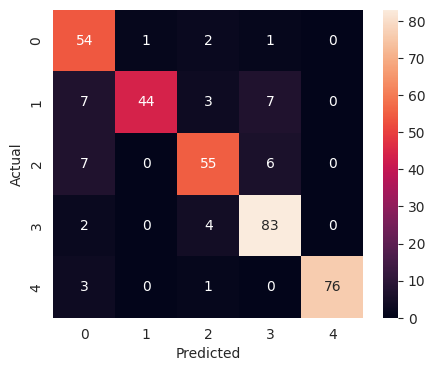

For Test Data


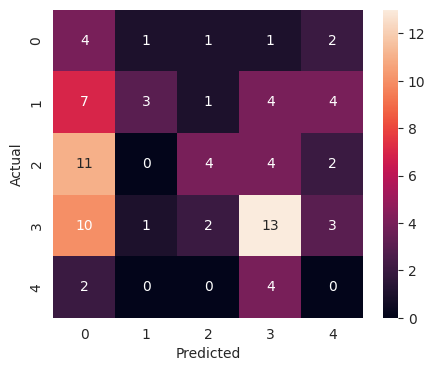

--------------------------------------------------
Classification Report for Train Data
              precision    recall  f1-score   support

           0       0.74      0.93      0.82        58
           1       0.98      0.72      0.83        61
           2       0.85      0.81      0.83        68
           3       0.86      0.93      0.89        89
           4       1.00      0.95      0.97        80

    accuracy                           0.88       356
   macro avg       0.88      0.87      0.87       356
weighted avg       0.89      0.88      0.88       356

--------------------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.12      0.44      0.19         9
           1       0.60      0.16      0.25        19
           2       0.50      0.19      0.28        21
           3       0.50      0.45      0.47        29
           4       0.00      0.00      0.00         6

    accura

In [ ]:
pred_plot_confusion_matrix ("Base Word2Vec",rf_word2vec, X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec)

In [ ]:
print(ListMetrics)

[['Base Word2Vec', 0.8764044943820225, 0.2857142857142857], ['Base Word2Vec', 0.8764044943820225, 0.2857142857142857]]


**Observations**

### WIth Word2Vec( with Class balancing)

In [ ]:
rf_word2vec_balanced = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_word2vec_balanced.fit(X_train_word2vec, y_train_word2vec)

RandomForestClassifier(class_weight='balanced', random_state=42)

For Train Data


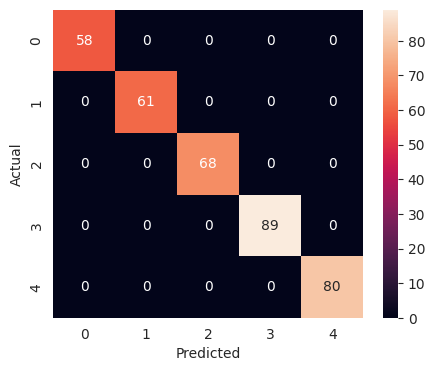

For Test Data


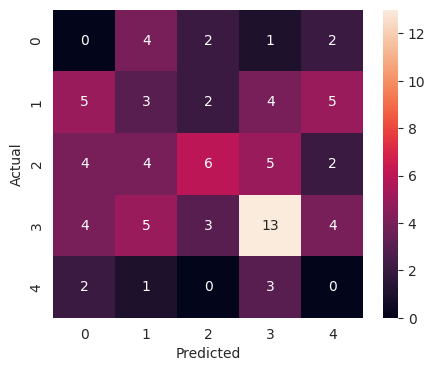

--------------------------------------------------
Classification Report for Train Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        61
           2       1.00      1.00      1.00        68
           3       1.00      1.00      1.00        89
           4       1.00      1.00      1.00        80

    accuracy                           1.00       356
   macro avg       1.00      1.00      1.00       356
weighted avg       1.00      1.00      1.00       356

--------------------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.18      0.16      0.17        19
           2       0.46      0.29      0.35        21
           3       0.50      0.45      0.47        29
           4       0.00      0.00      0.00         6

    accura

In [ ]:
pred_plot_confusion_matrix ("Balanced Word2Vec",rf_word2vec_balanced, X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec)

**Observations**

### **Random Forest with Glove**

In [ ]:
# Concatenating the features from transformer vectorization with the other columns from the dataset

# df_Glove= pd.concat([data.iloc[:, :-1],df_Glove_vec], axis=1)
df_tmp = data.drop(columns=['Description'])
df_Glove= pd.concat([df_tmp,df_Glove_vec], axis=1)

In [ ]:
# X_glove = df_Glove.drop(targetColumn, axis=1)

# # Storing target variable
# y_glove= df_Glove[targetColumn]

In [ ]:
# # Split data into training and testing set.
# X_train_glove, X_temp_glove, y_train_glove, y_temp_glove = train_test_split(X_glove ,y_glove, test_size = 0.3, random_state = 42)
# # Split temp dataset into test and valdiation set
# X_test_glove, X_val_glove, y_test_glove, y_val_glove = train_test_split(X_temp_glove ,y_temp_glove, test_size = 0.15, random_state = 42)

In [ ]:
# Extract Train data
df_train_glove = df_Glove[df_Glove['data_type'] == 'train']
df_train_glove.drop('data_type', axis=1, inplace=True)
X_train_glove = df_train_glove.drop(targetColumn, axis=1)
y_train_glove = df_train_glove[targetColumn]

# Extract Validation data
df_val_glove = df_Glove[df_Glove['data_type'] == 'val']
df_val_glove.drop('data_type', axis=1, inplace=True)
X_val_glove = df_val_glove.drop(targetColumn, axis=1)
y_val_glove = df_val_glove[targetColumn]

# Extract Test data
df_test_glove = df_Glove[df_Glove['data_type'] == 'test']
df_test_glove.drop('data_type', axis=1, inplace=True)
X_test_glove = df_test_glove.drop(targetColumn, axis=1)
y_test_glove = df_test_glove[targetColumn]

In [ ]:
# Building the model
rf_glove = RandomForestClassifier(n_estimators = 100, max_depth = 7, random_state = 42)

# Fitting on train data
rf_glove.fit(X_train_glove, y_train_glove)

RandomForestClassifier(max_depth=7, random_state=42)

For Train Data


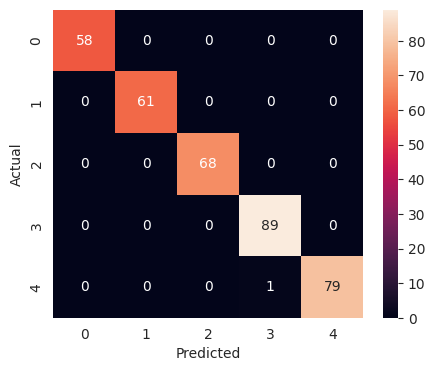

For Test Data


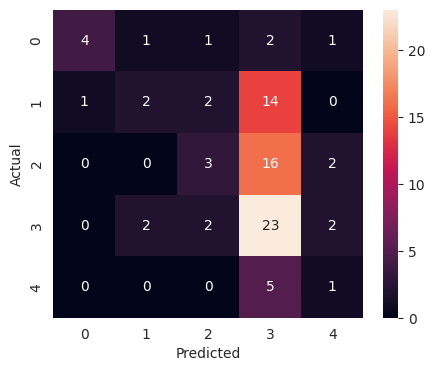

--------------------------------------------------
Classification Report for Train Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        61
           2       1.00      1.00      1.00        68
           3       0.99      1.00      0.99        89
           4       1.00      0.99      0.99        80

    accuracy                           1.00       356
   macro avg       1.00      1.00      1.00       356
weighted avg       1.00      1.00      1.00       356

--------------------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.80      0.44      0.57         9
           1       0.40      0.11      0.17        19
           2       0.38      0.14      0.21        21
           3       0.38      0.79      0.52        29
           4       0.17      0.17      0.17         6

    accura

In [ ]:
pred_plot_confusion_matrix ("Base Glove",rf_glove, X_train_glove, X_test_glove, y_train_glove, y_test_glove)

### With Glove( with Class balancing)

In [ ]:
rf_glove_balanced = RandomForestClassifier(class_weight="balanced", random_state=42)
rf_glove_balanced.fit(X_train_glove, y_train_glove)

RandomForestClassifier(class_weight='balanced', random_state=42)

For Train Data


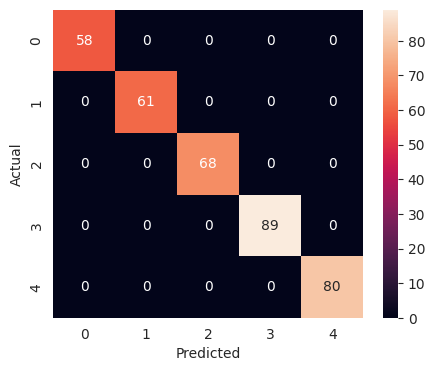

For Test Data


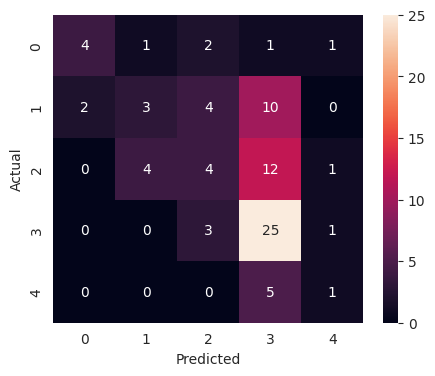

--------------------------------------------------
Classification Report for Train Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        61
           2       1.00      1.00      1.00        68
           3       1.00      1.00      1.00        89
           4       1.00      1.00      1.00        80

    accuracy                           1.00       356
   macro avg       1.00      1.00      1.00       356
weighted avg       1.00      1.00      1.00       356

--------------------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.67      0.44      0.53         9
           1       0.38      0.16      0.22        19
           2       0.31      0.19      0.24        21
           3       0.47      0.86      0.61        29
           4       0.25      0.17      0.20         6

    accura

In [ ]:
pred_plot_confusion_matrix ("Balanced Glove",rf_glove_balanced, X_train_glove, X_test_glove, y_train_glove, y_test_glove)

### **Random Forest with Transformers**

In [ ]:
# Concatenating the features from transformer vectorization with the other columns from the dataset

# df_transformer =pd.concat([data.iloc[:, :-1],df_transformers_vec], axis=1)

df_tmp = data.drop(columns=['Description'])
df_transformer= pd.concat([df_tmp,df_transformers_vec], axis=1)

In [ ]:
# # Process the data

# X_transformer = df_transformer.drop(targetColumn, axis=1)
# y_transformer = df_transformer[targetColumn]

In [ ]:
# X_train_transformer, X_temp_transformer, y_train_transformer, y_temp_transformer = train_test_split(X_transformer, y_transformer, test_size=0.25, random_state=42)

# X_test_transformer, X_val_transformer, y_test_transformer, y_val_transformer = train_test_split(X_temp_transformer ,y_temp_transformer, test_size = 0.15, random_state = 42)

In [ ]:
# Extract Train data
df_train_transformer = df_transformer[df_transformer['data_type'] == 'train']
df_train_transformer.drop('data_type', axis=1, inplace=True)
X_train_transformer = df_train_transformer.drop(targetColumn, axis=1)
y_train_transformer = df_train_transformer[targetColumn]

# Extract Validation data
df_val_transformer = df_transformer[df_transformer['data_type'] == 'val']
df_val_transformer.drop('data_type', axis=1, inplace=True)
X_val_transformer = df_val_transformer.drop(targetColumn, axis=1)
y_val_transformer = df_val_transformer[targetColumn]

# Extract Test data
df_test_transformer = df_transformer[df_transformer['data_type'] == 'test']
df_test_transformer.drop('data_type', axis=1, inplace=True)
X_test_transformer = df_test_transformer.drop(targetColumn, axis=1)
y_test_transformer = df_test_transformer[targetColumn]

In [ ]:
# build a RF model

# Building the model
rf_transformer = RandomForestClassifier(n_estimators = 100, max_depth = 7, random_state = 42)

# Fitting on train data
rf_transformer.fit(X_train_transformer, y_train_transformer)

RandomForestClassifier(max_depth=7, random_state=42)

For Train Data


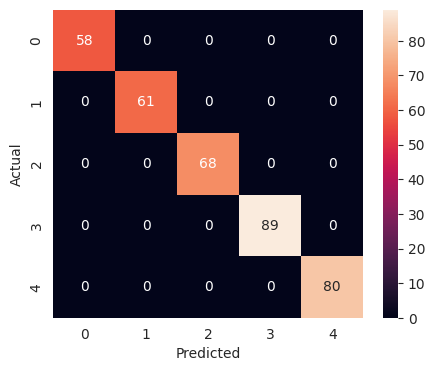

For Test Data


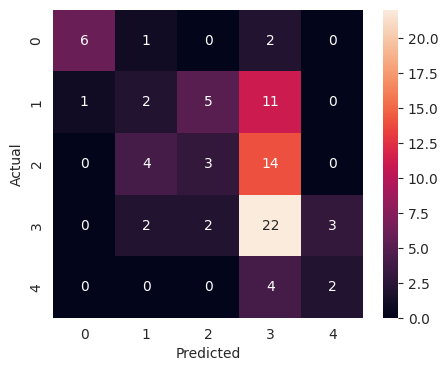

--------------------------------------------------
Classification Report for Train Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        61
           2       1.00      1.00      1.00        68
           3       1.00      1.00      1.00        89
           4       1.00      1.00      1.00        80

    accuracy                           1.00       356
   macro avg       1.00      1.00      1.00       356
weighted avg       1.00      1.00      1.00       356

--------------------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.22      0.11      0.14        19
           2       0.30      0.14      0.19        21
           3       0.42      0.76      0.54        29
           4       0.40      0.33      0.36         6

    accura

In [ ]:
pred_plot_confusion_matrix ("Base Transformer",rf_transformer, X_train_transformer, X_test_transformer, y_train_transformer, y_test_transformer )

### With Transformer( with Class balancing)

In [ ]:
# build a RF model

# Building the model
rf_transformer_balanced = RandomForestClassifier(class_weight="balanced",random_state = 42)

# Fitting on train data
rf_transformer_balanced.fit(X_train_transformer, y_train_transformer)

RandomForestClassifier(class_weight='balanced', random_state=42)

For Train Data


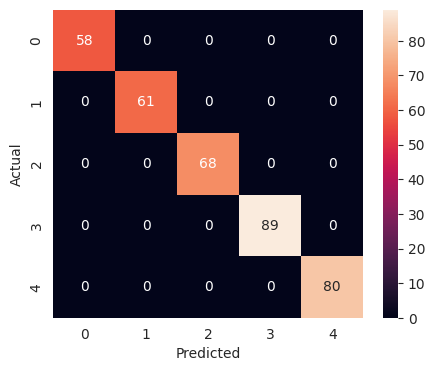

For Test Data


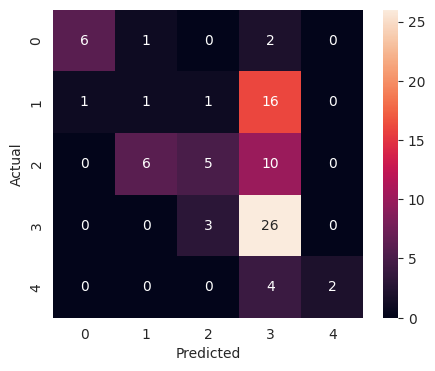

--------------------------------------------------
Classification Report for Train Data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        61
           2       1.00      1.00      1.00        68
           3       1.00      1.00      1.00        89
           4       1.00      1.00      1.00        80

    accuracy                           1.00       356
   macro avg       1.00      1.00      1.00       356
weighted avg       1.00      1.00      1.00       356

--------------------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.86      0.67      0.75         9
           1       0.12      0.05      0.07        19
           2       0.56      0.24      0.33        21
           3       0.45      0.90      0.60        29
           4       1.00      0.33      0.50         6

    accura

In [ ]:
pred_plot_confusion_matrix ("Balanced Transformer",rf_transformer_balanced, X_train_transformer, X_test_transformer, y_train_transformer, y_test_transformer )

In [ ]:
dfMetrics = pd.DataFrame(ListMetrics, columns=["Model", "Train Accuracy", "Test Accuracy"])
print(dfMetrics)

                  Model  Train Accuracy  Test Accuracy
0         Base Word2Vec        0.876404       0.285714
1         Base Word2Vec        0.876404       0.285714
2     Balanced Word2Vec        1.000000       0.261905
3            Base Glove        0.997191       0.392857
4        Balanced Glove        1.000000       0.440476
5      Base Transformer        1.000000       0.416667
6  Balanced Transformer        1.000000       0.476190


### Retrying with HyperParameter tuning

In [ ]:
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
def TunedModel(X_train, y_train):
    # Choose the type of classifier
    rf_tuned = RandomForestClassifier(class_weight="balanced", random_state=42)

    # defining the hyperparameter grid for tuning
    parameters = {
        "max_depth": list(np.arange(4, 15, 20)),
        "max_features": ["sqrt", 0.5, 0.7],
        "min_samples_split": [5, 6, 7],
        "n_estimators": np.arange(30, 110, 10),
    }

    # defining the type of scoring used to compare parameter combinations
    # we need to specify the mechanism of averaging as we have more than 2 target classes
    # scorer = metrics.make_scorer(metrics.recall_score, average='weighted')

    # Define a custom recall scorer for classes 2, 3, and 4
    def custom_recall_scorer(y_true, y_pred):
        recall_scores = recall_score(y_true, y_pred, labels=[2, 3, 4], average=None)
        return np.mean(recall_scores)

    # Create a scorer using make_scorer
    recall_scorer = make_scorer(custom_recall_scorer)

    # running the grid search
    # grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer, cv=3, n_jobs=-1)
    grid_obj = RandomizedSearchCV(rf_tuned, parameters, scoring=recall_scorer, cv=3, n_jobs=-1)
    grid_obj = grid_obj.fit(X_train, y_train)
    return grid_obj

### Word2Vec With TUning

In [ ]:
rf_word2Vec_balanced_tuned = TunedModel(X_train_word2vec,y_train_word2vec )

For Train Data


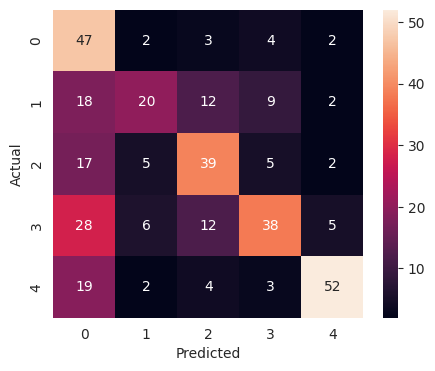

For Test Data


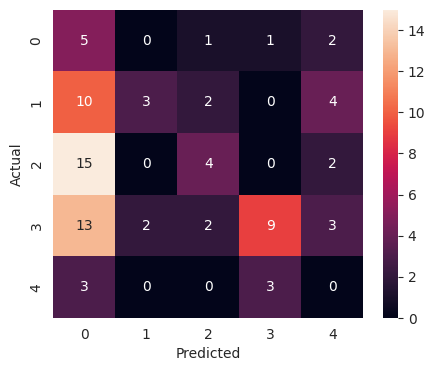

--------------------------------------------------
Classification Report for Train Data
              precision    recall  f1-score   support

           0       0.36      0.81      0.50        58
           1       0.57      0.33      0.42        61
           2       0.56      0.57      0.57        68
           3       0.64      0.43      0.51        89
           4       0.83      0.65      0.73        80

    accuracy                           0.55       356
   macro avg       0.59      0.56      0.55       356
weighted avg       0.61      0.55      0.55       356

--------------------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.11      0.56      0.18         9
           1       0.60      0.16      0.25        19
           2       0.44      0.19      0.27        21
           3       0.69      0.31      0.43        29
           4       0.00      0.00      0.00         6

    accura

In [ ]:
pred_plot_confusion_matrix ("Tuned Word2Vec",rf_word2Vec_balanced_tuned, X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec)

### Glove(with tuning)

In [ ]:
rf_glove_balanced_tuned = TunedModel(X_train_glove,y_train_glove )

For Train Data


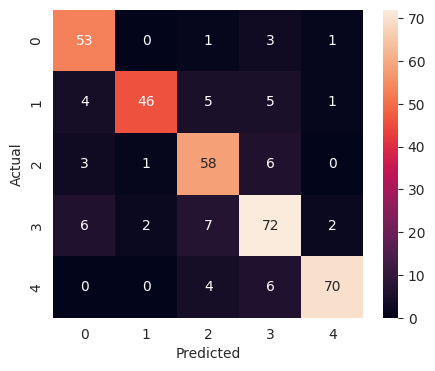

For Test Data


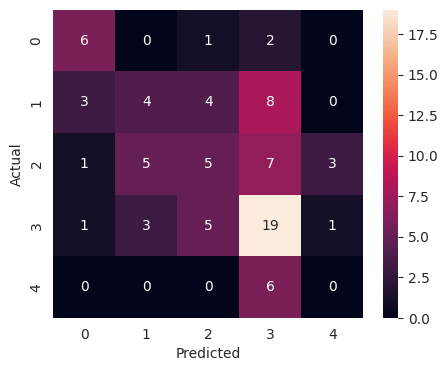

--------------------------------------------------
Classification Report for Train Data
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        58
           1       0.94      0.75      0.84        61
           2       0.77      0.85      0.81        68
           3       0.78      0.81      0.80        89
           4       0.95      0.88      0.91        80

    accuracy                           0.84       356
   macro avg       0.85      0.84      0.84       356
weighted avg       0.85      0.84      0.84       356

--------------------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.55      0.67      0.60         9
           1       0.33      0.21      0.26        19
           2       0.33      0.24      0.28        21
           3       0.45      0.66      0.54        29
           4       0.00      0.00      0.00         6

    accura

In [ ]:
pred_plot_confusion_matrix ("Tuned Glove",rf_glove_balanced_tuned, X_train_glove, X_test_glove, y_train_glove, y_test_glove)

### With Transformers( Tuned)

In [ ]:
rf_transformer_balanced_tuned= TunedModel(X_train_transformer,y_train_transformer )

For Train Data


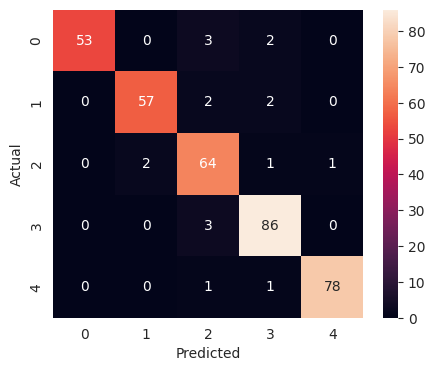

For Test Data


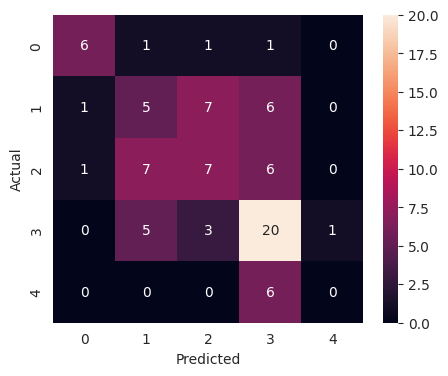

--------------------------------------------------
Classification Report for Train Data
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        58
           1       0.97      0.93      0.95        61
           2       0.88      0.94      0.91        68
           3       0.93      0.97      0.95        89
           4       0.99      0.97      0.98        80

    accuracy                           0.95       356
   macro avg       0.95      0.95      0.95       356
weighted avg       0.95      0.95      0.95       356

--------------------------------------------------
Classification Report for Test Data
              precision    recall  f1-score   support

           0       0.75      0.67      0.71         9
           1       0.28      0.26      0.27        19
           2       0.39      0.33      0.36        21
           3       0.51      0.69      0.59        29
           4       0.00      0.00      0.00         6

    accura

In [ ]:
pred_plot_confusion_matrix ("Tuned Transformer",rf_transformer_balanced_tuned, X_train_transformer, X_test_transformer, y_train_transformer, y_test_transformer)

In [ ]:
dfMetrics = pd.DataFrame(ListMetrics, columns=["Model", "Train Accuracy", "Test Accuracy"])
print(dfMetrics)

                  Model  Train Accuracy  Test Accuracy
0         Base Word2Vec        0.876404       0.285714
1         Base Word2Vec        0.876404       0.285714
2     Balanced Word2Vec        1.000000       0.261905
3            Base Glove        0.997191       0.392857
4        Balanced Glove        1.000000       0.440476
5      Base Transformer        1.000000       0.416667
6  Balanced Transformer        1.000000       0.476190
7        Tuned Word2Vec        0.550562       0.250000
8           Tuned Glove        0.839888       0.404762
9     Tuned Transformer        0.949438       0.452381
